# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import PIL
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
import glob
import cv2
import seaborn as sns
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os, shutil
import sys
import shutil
import json
import glob as gb

In [2]:
videos_folder = "train_sample_videos"


metadata_file = os.path.join(videos_folder, "metadata.json")

with open(metadata_file, 'r') as json_file:
    metadata = json.load(json_file)


for video_filename, video_info in metadata.items():
    label = video_info["label"]
    source_path = os.path.join(videos_folder, video_filename)
    destination_folder = os.path.join(videos_folder, label.upper())


    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    
    destination_path = os.path.join(destination_folder, video_filename)
    shutil.move(source_path, destination_path)

# Preparing the dataset

In [2]:
real_videos_folder = 'train_sample_videos/REAL'
fake_videos_folder = 'train_sample_videos/FAKE'

def process_videos(video_folder, output_folder):
    list_of_data = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    detector = dlib.get_frontal_face_detector()

    for vid in list_of_data:
        count = 0
        cap = cv2.VideoCapture(os.path.join(video_folder, vid))

        while cap.isOpened():
            ret, frame = cap.read()

            if not ret or frame is None or frame.size == 0:
                break

            face_rects, _, _ = detector.run(frame, 0)

            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]

                if crop_img.size != 0:
                    resized_img = cv2.resize(crop_img, (128, 128))
                    cv2.imwrite(os.path.join(output_folder, vid.split('.')[0] + '_' + str(count) + '.png'), resized_img)
                    count += 1

    cap.release()

In [ ]:
process_videos(real_videos_folder, 'data/real')

In [5]:
process_videos(fake_videos_folder, 'data/fake')

# Loading the dataset

In [6]:

class config:
    
    data_path = 'data/'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [7]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.8, .2))

Copying files: 111472 files [01:05, 1699.68 files/s]


# EDA

In [13]:
BATCH_SIZE = 64
IMAGE_SHAPE = (128, 128)

In [14]:
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

In [15]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 89177 images belonging to 2 classes.
Found 22295 images belonging to 2 classes.


# Data Visualization

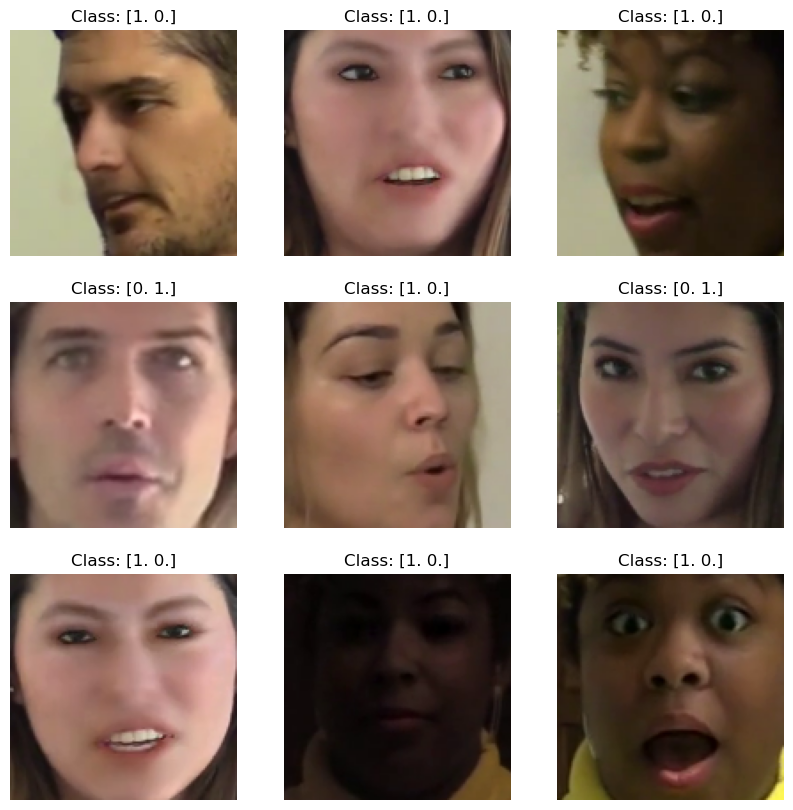

In [35]:
def plot_images(generator, num_images=9):
    
    images, labels = generator.next()

    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {labels[i]}')
        plt.axis('off')
    
    plt.show()


plot_images(train_gen)



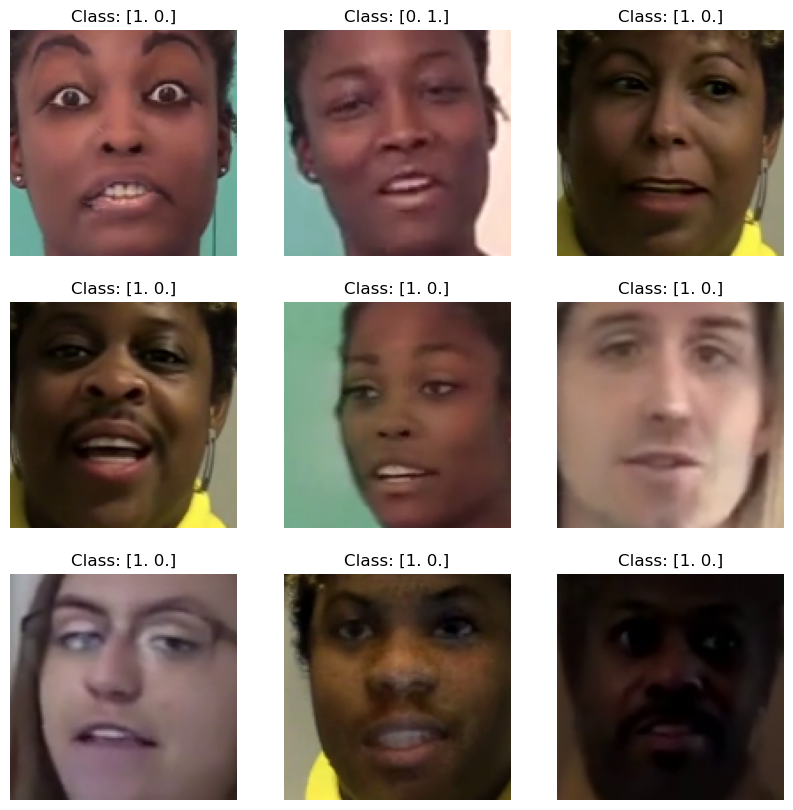

In [36]:
plot_images(val_gen)

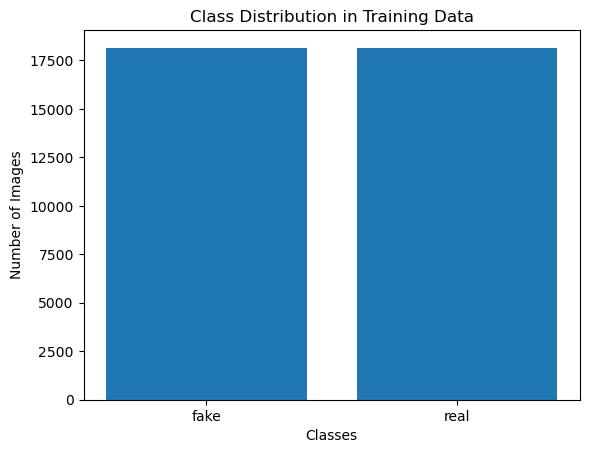

In [37]:
class_counts = np.sum(train_gen.labels, axis=0)
classes = list(train_gen.class_indices.keys())

plt.bar(classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.show()

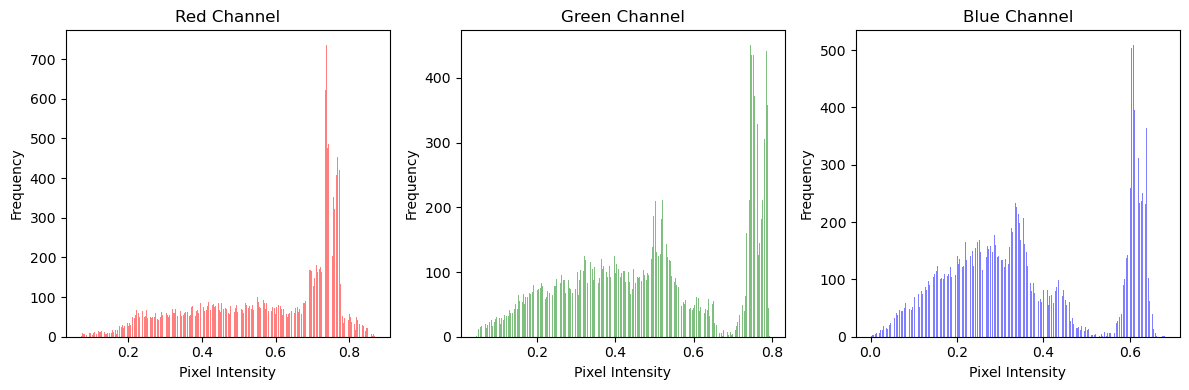

In [38]:
def plot_pixel_intensity(image):
    plt.figure(figsize=(12, 4))

   
    plt.subplot(1, 3, 1)
    plt.hist(image[:, :, 0].ravel(), bins=256, color='red', alpha=0.5, rwidth=0.8)
    plt.title('Red Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    
    plt.subplot(1, 3, 2)
    plt.hist(image[:, :, 1].ravel(), bins=256, color='green', alpha=0.5, rwidth=0.8)
    plt.title('Green Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    
    plt.subplot(1, 3, 3)
    plt.hist(image[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5, rwidth=0.8)
    plt.title('Blue Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


sample_image = train_gen[0][0][0]  
plot_pixel_intensity(sample_image)

In [11]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Model Building

In [39]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

### Inception-ResNet-v2

In [40]:
inc = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 63, 63, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d_8[0][0]']               
 alization)                                                                                       
                                                                                            

 batch_normalization_10 (BatchN  (None, 13, 13, 96)  288         ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 13, 13, 64)  192         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 13, 13, 96)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 13, 13, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 batch_normalization_19 (BatchN  (None, 13, 13, 32)  96          ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 13, 13, 48)  144         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 13, 13, 32)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_22 (Activation)     (None, 13, 13, 48)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_26

                                                                                                  
 block35_3_mixed (Concatenate)  (None, 13, 13, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
                                                                                                  
 block35_3_conv (Conv2D)        (None, 13, 13, 320)  41280       ['block35_3_mixed[0][0]']        
                                                                                                  
 block35_3 (Lambda)             (None, 13, 13, 320)  0           ['block35_2_ac[0][0]',           
                                                                  'block35_3_conv[0][0]']         
                                                                                                  
 block35_3

                                                                                                  
 activation_40 (Activation)     (None, 13, 13, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 13, 13, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_46 (Conv2D)             (None, 13, 13, 32)   9216        ['activation_37[0][0]']          
                                                                                                  
 conv2d_49 (Conv2D)             (None, 13, 13, 64)   27648       ['activation_40[0][0]']          
                                                                                                  
 batch_normalization_36 (BatchN  (None, 13, 13, 32)  96          ['conv2d_44[0][0]']              
 ormalizat

 block35_6 (Lambda)             (None, 13, 13, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 13, 13, 320)  0           ['block35_6[0][0]']              
                                                                                                  
 conv2d_59 (Conv2D)             (None, 13, 13, 32)   10240       ['block35_6_ac[0][0]']           
                                                                                                  
 batch_normalization_51 (BatchN  (None, 13, 13, 32)  96          ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_67 (Conv2D)             (None, 13, 13, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 13, 13, 32)  96          ['conv2d_62[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_56 (BatchN  (None, 13, 13, 32)  96          ['conv2d_64[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_59 (BatchN  (None, 13, 13, 64)  192         ['conv2d_67[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_69 (BatchN  (None, 13, 13, 32)  96          ['conv2d_77[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 13, 13, 32)   0           ['batch_normalization_69[0][0]'] 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 13, 13, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 conv2d_78 (Conv2D)             (None, 13, 13, 48)   13824       ['activation_69[0][0]']          
                                                                                                  
 batch_normalization_67 (BatchN  (None, 13, 13, 32)  96          ['conv2d_75[0][0]']              
 ormalizat

                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_85 (Conv2D)             (None, 6, 6, 128)    139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_normalization_77 (BatchN  (None, 6, 6, 128)   384         ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 6, 6, 128)    0           ['batch_normalization_77[0][0]'] 
                                                                                                  
 conv2d_86 (Conv2D)             (None, 6, 6, 160)    143360      ['activation_77[0][0]']          
          

 activation_85 (Activation)     (None, 6, 6, 128)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 6, 6, 160)    143360      ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_86 (BatchN  (None, 6, 6, 160)   480         ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_86 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_86[0][0]'] 
                                                                                                  
 conv2d_92 (Conv2D)             (None, 6, 6, 192)    208896      ['block17_2_ac[0][0]']           
          

 activation_94 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_100 (Conv2D)            (None, 6, 6, 192)    208896      ['block17_4_ac[0][0]']           
                                                                                                  
 conv2d_103 (Conv2D)            (None, 6, 6, 192)    215040      ['activation_94[0][0]']          
                                                                                                  
 batch_normalization_92 (BatchN  (None, 6, 6, 192)   576         ['conv2d_100[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_95 (BatchN  (None, 6, 6, 192)   576         ['conv2d_103[0][0]']             
 ormalizat

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_103 (Batch  (None, 6, 6, 192)   576         ['conv2d_111[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_100 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_100[0][0]']
                                                                                                  
 activation_103 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_103[0][0]']
                                                                                                  
 block17_7_mixed (Concatenate)  (None, 6, 6, 384)    0           ['activation_100[0][0]',         
          

 activation_111 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_111[0][0]']
                                                                                                  
 block17_9_mixed (Concatenate)  (None, 6, 6, 384)    0           ['activation_108[0][0]',         
                                                                  'activation_111[0][0]']         
                                                                                                  
 block17_9_conv (Conv2D)        (None, 6, 6, 1088)   418880      ['block17_9_mixed[0][0]']        
                                                                                                  
 block17_9 (Lambda)             (None, 6, 6, 1088)   0           ['block17_8_ac[0][0]',           
                                                                  'block17_9_conv[0][0]']         
                                                                                                  
 block17_9

 block17_11 (Lambda)            (None, 6, 6, 1088)   0           ['block17_10_ac[0][0]',          
                                                                  'block17_11_conv[0][0]']        
                                                                                                  
 block17_11_ac (Activation)     (None, 6, 6, 1088)   0           ['block17_11[0][0]']             
                                                                                                  
 conv2d_129 (Conv2D)            (None, 6, 6, 128)    139264      ['block17_11_ac[0][0]']          
                                                                                                  
 batch_normalization_121 (Batch  (None, 6, 6, 128)   384         ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_129 (Batch  (None, 6, 6, 128)   384         ['conv2d_137[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_129 (Activation)    (None, 6, 6, 128)    0           ['batch_normalization_129[0][0]']
                                                                                                  
 conv2d_138 (Conv2D)            (None, 6, 6, 160)    143360      ['activation_129[0][0]']         
                                                                                                  
 batch_normalization_130 (Batch  (None, 6, 6, 160)   480         ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_138 (Batch  (None, 6, 6, 160)   480         ['conv2d_146[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 6, 6, 160)    0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_144 (Conv2D)            (None, 6, 6, 192)    208896      ['block17_15_ac[0][0]']          
                                                                                                  
 conv2d_147 (Conv2D)            (None, 6, 6, 192)    215040      ['activation_138[0][0]']         
                                                                                                  
 batch_normalization_136 (Batch  (None, 6, 6, 192)   576         ['conv2d_144[0][0]']             
 Normaliza

 conv2d_155 (Conv2D)            (None, 6, 6, 192)    215040      ['activation_146[0][0]']         
                                                                                                  
 batch_normalization_144 (Batch  (None, 6, 6, 192)   576         ['conv2d_152[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_147 (Batch  (None, 6, 6, 192)   576         ['conv2d_155[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_144 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_144[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_152 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_152[0][0]']
                                                                                                  
 activation_155 (Activation)    (None, 6, 6, 192)    0           ['batch_normalization_155[0][0]']
                                                                                                  
 block17_20_mixed (Concatenate)  (None, 6, 6, 384)   0           ['activation_152[0][0]',         
                                                                  'activation_155[0][0]']         
                                                                                                  
 block17_20_conv (Conv2D)       (None, 6, 6, 1088)   418880      ['block17_20_mixed[0][0]']       
                                                                                                  
 block17_2

 activation_165 (Activation)    (None, 2, 2, 224)    0           ['batch_normalization_165[0][0]']
                                                                                                  
 conv2d_171 (Conv2D)            (None, 2, 2, 192)    399360      ['mixed_7a[0][0]']               
                                                                                                  
 conv2d_174 (Conv2D)            (None, 2, 2, 256)    172032      ['activation_165[0][0]']         
                                                                                                  
 batch_normalization_163 (Batch  (None, 2, 2, 192)   576         ['conv2d_171[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_166 (Batch  (None, 2, 2, 256)   768         ['conv2d_174[0][0]']             
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_174 (Batch  (None, 2, 2, 256)   768         ['conv2d_182[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_171 (Activation)    (None, 2, 2, 192)    0           ['batch_normalization_171[0][0]']
                                                                                                  
 activation_174 (Activation)    (None, 2, 2, 256)    0           ['batch_normalization_174[0][0]']
                                                                                                  
 block8_3_mixed (Concatenate)   (None, 2, 2, 448)    0           ['activation_171[0][0]',         
          

 activation_182 (Activation)    (None, 2, 2, 256)    0           ['batch_normalization_182[0][0]']
                                                                                                  
 block8_5_mixed (Concatenate)   (None, 2, 2, 448)    0           ['activation_179[0][0]',         
                                                                  'activation_182[0][0]']         
                                                                                                  
 block8_5_conv (Conv2D)         (None, 2, 2, 2080)   933920      ['block8_5_mixed[0][0]']         
                                                                                                  
 block8_5 (Lambda)              (None, 2, 2, 2080)   0           ['block8_4_ac[0][0]',            
                                                                  'block8_5_conv[0][0]']          
                                                                                                  
 block8_5_

 block8_7 (Lambda)              (None, 2, 2, 2080)   0           ['block8_6_ac[0][0]',            
                                                                  'block8_7_conv[0][0]']          
                                                                                                  
 block8_7_ac (Activation)       (None, 2, 2, 2080)   0           ['block8_7[0][0]']               
                                                                                                  
 conv2d_200 (Conv2D)            (None, 2, 2, 192)    399360      ['block8_7_ac[0][0]']            
                                                                                                  
 batch_normalization_192 (Batch  (None, 2, 2, 192)   576         ['conv2d_200[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 batch_normalization_200 (Batch  (None, 2, 2, 192)   576         ['conv2d_208[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_200 (Activation)    (None, 2, 2, 192)    0           ['batch_normalization_200[0][0]']
                                                                                                  
 conv2d_209 (Conv2D)            (None, 2, 2, 224)    129024      ['activation_200[0][0]']         
                                                                                                  
 batch_normalization_201 (Batch  (None, 2, 2, 224)   672         ['conv2d_209[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [41]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 208s 137ms/step - loss: 0.0956 - accuracy: 0.9671 - f1_score: 0.9671 - recall_m: 0.9671 - precision_m: 0.9671 - specificity_m: 0.9671 - sensitivity_m: 0.9671 - mae: 0.0481 - mse: 0.0252 - val_loss: 67.8582 - val_accuracy: 0.8824 - val_f1_score: 0.8826 - val_recall_m: 0.8826 - val_precision_m: 0.8826 - val_specificity_m: 0.8826 - val_sensitivity_m: 0.8826 - val_mae: 0.1344 - val_mse: 0.1061
Epoch 2/50
1394/1394 [==============================] - 187s 134ms/step - loss: 0.0856 - accuracy: 0.9705 - f1_score: 0.9705 - recall_m: 0.9705 - precision_m: 0.9705 - specificity_m: 0.9705 - sensitivity_m: 0.9705 - mae: 0.0445 - mse: 0.0228 - val_loss: 75.7282 - val_accuracy: 0.2888 - val_f1_score: 0.2890 - val_recall_m: 0.2890 - val_precision_m: 0.2890 - val_specificity_m: 0.2890 - val_sensitivity_m: 0.2890 - val_mae: 0.7117 - val_mse: 0.7002
Epoch 3/50
1394/1394 [==============================] - 187s 134ms/step - loss: 0.0800 - accuracy: 0.9

In [42]:
model.save('models/Inceptionresnet_v2.h5')

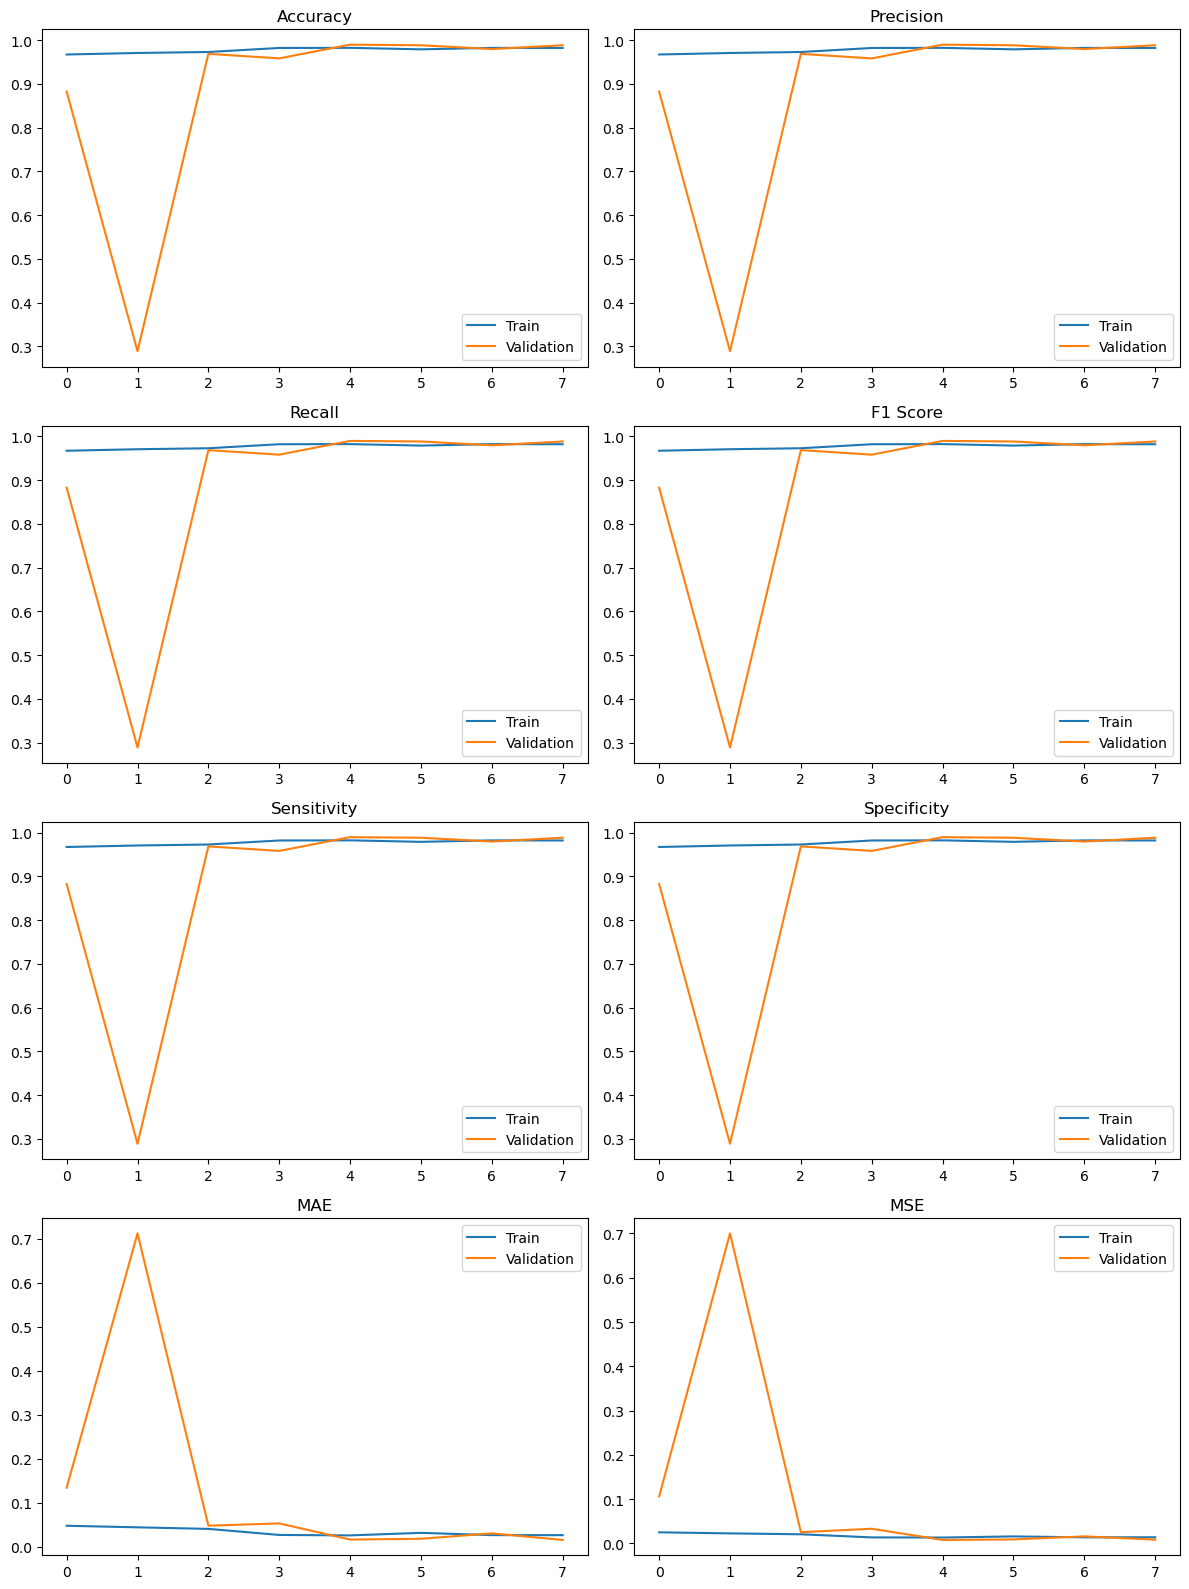

In [43]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 26s 67ms/step


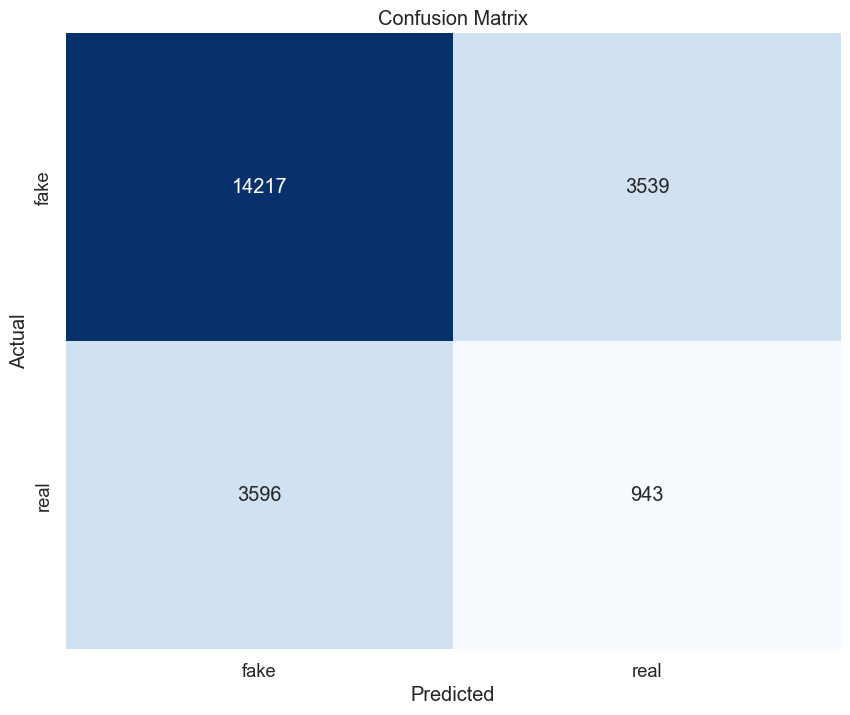

In [44]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [45]:
a = history.history['accuracy'][-1]
f = history.history['f1_score'][-1]
p = history.history['precision_m'][-1]
r = history.history['recall_m'][-1]
mae = history.history['mae'][-1]
mse = history.history['mse'][-1]
specificity = history.history['specificity_m'][-1]  
sensitivity = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a * 100))
print('Precision = ' + str(p * 100))
print('F1 Score = ' + str(f * 100))
print('Recall = ' + str(r * 100))
print('MAE = ' + str(mae))
print('MSE = ' + str(mse))
print('Sensitivity = ' + str(sensitivity * 100))  
print('Specificity = ' + str(specificity * 100))

Accuracy = 98.20132851600647
Precision = 98.19861054420471
F1 Score = 98.19861054420471
Recall = 98.19861054420471
MAE = 0.02672160603106022
MSE = 0.0139885563403368
Sensitivity = 98.19861054420471
Specificity = 98.19861054420471


# VGG19

In [46]:
inc = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [48]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [49]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 124s 86ms/step - loss: 0.5004 - accuracy: 0.8235 - f1_score: 0.8235 - recall_m: 0.8235 - precision_m: 0.8235 - specificity_m: 0.8235 - sensitivity_m: 0.8235 - mae: 0.2658 - mse: 0.1341 - val_loss: 0.2176 - val_accuracy: 0.9167 - val_f1_score: 0.9168 - val_recall_m: 0.9168 - val_precision_m: 0.9168 - val_specificity_m: 0.9168 - val_sensitivity_m: 0.9168 - val_mae: 0.1350 - val_mse: 0.0632
Epoch 2/50
1394/1394 [==============================] - 117s 84ms/step - loss: 0.1609 - accuracy: 0.9382 - f1_score: 0.9382 - recall_m: 0.9382 - precision_m: 0.9382 - specificity_m: 0.9382 - sensitivity_m: 0.9382 - mae: 0.0927 - mse: 0.0464 - val_loss: 0.1083 - val_accuracy: 0.9571 - val_f1_score: 0.9571 - val_recall_m: 0.9571 - val_precision_m: 0.9571 - val_specificity_m: 0.9571 - val_sensitivity_m: 0.9571 - val_mae: 0.0570 - val_mse: 0.0315
Epoch 3/50
1394/1394 [==============================] - 116s 83ms/step - loss: 0.0811 - accuracy: 0.9705 -

In [50]:
model.save('models/vgg19.h5')

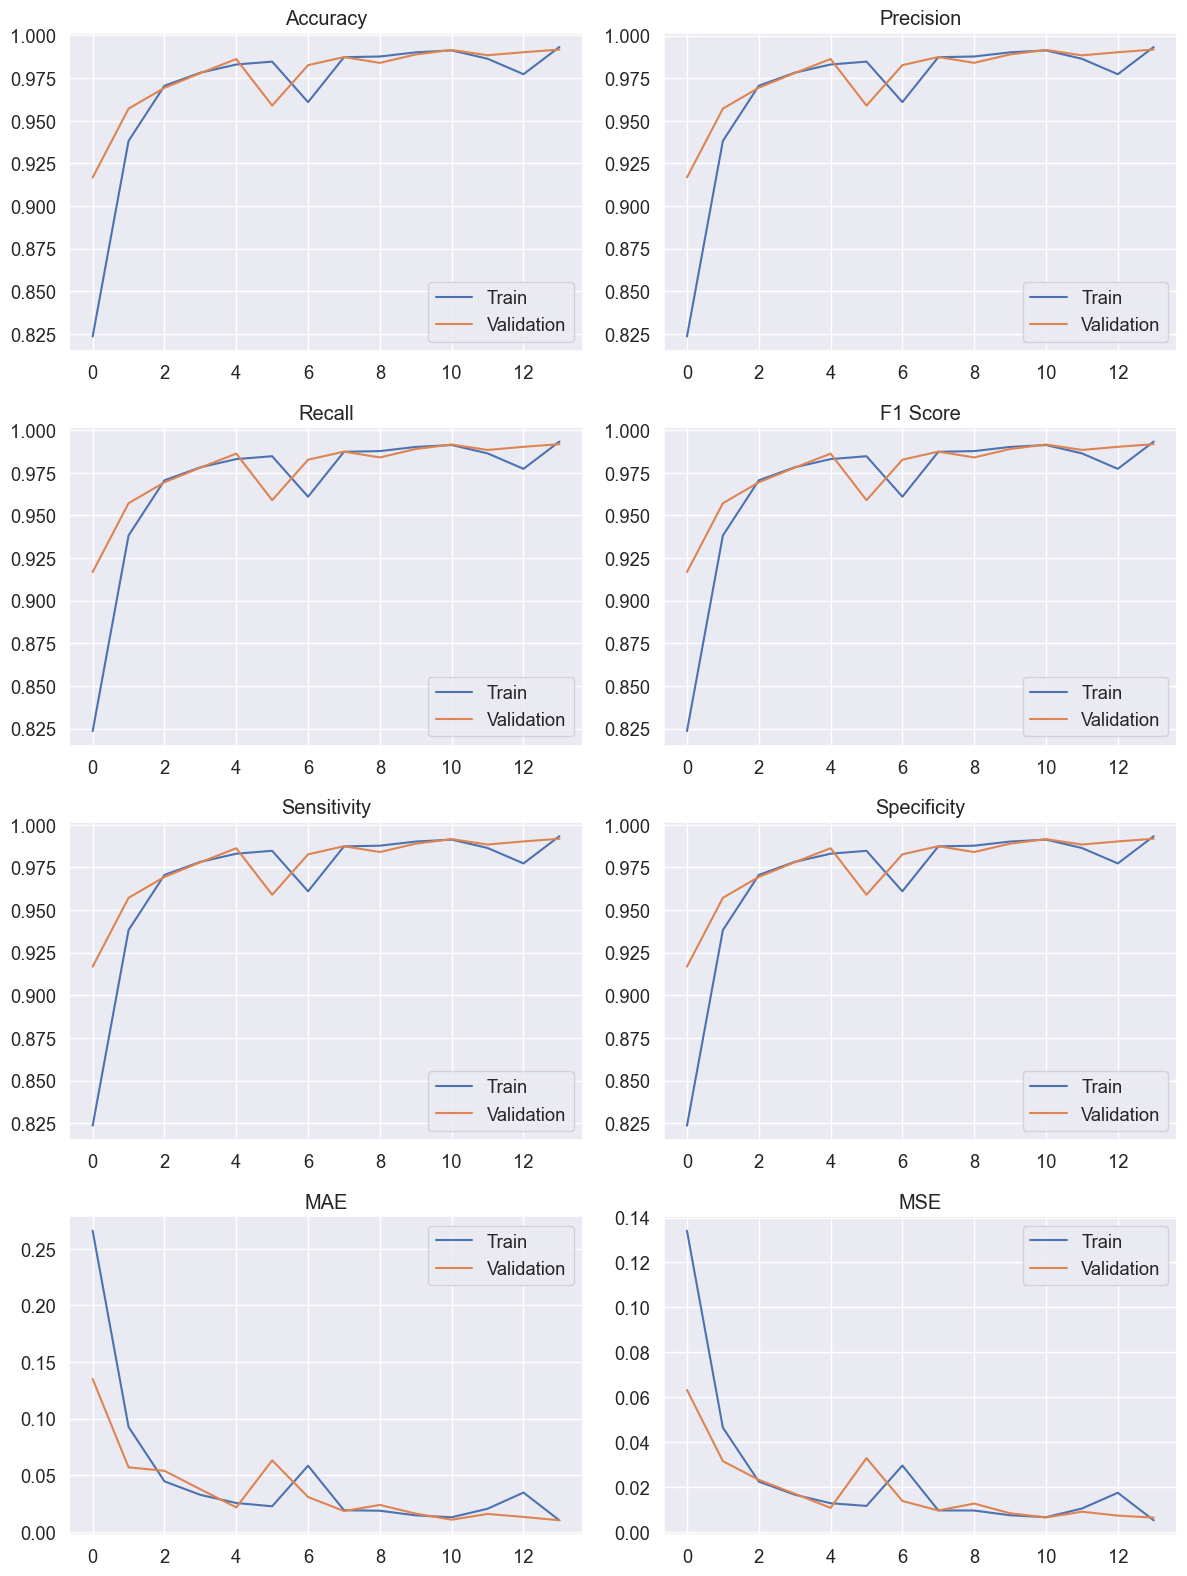

In [51]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 23s 66ms/step


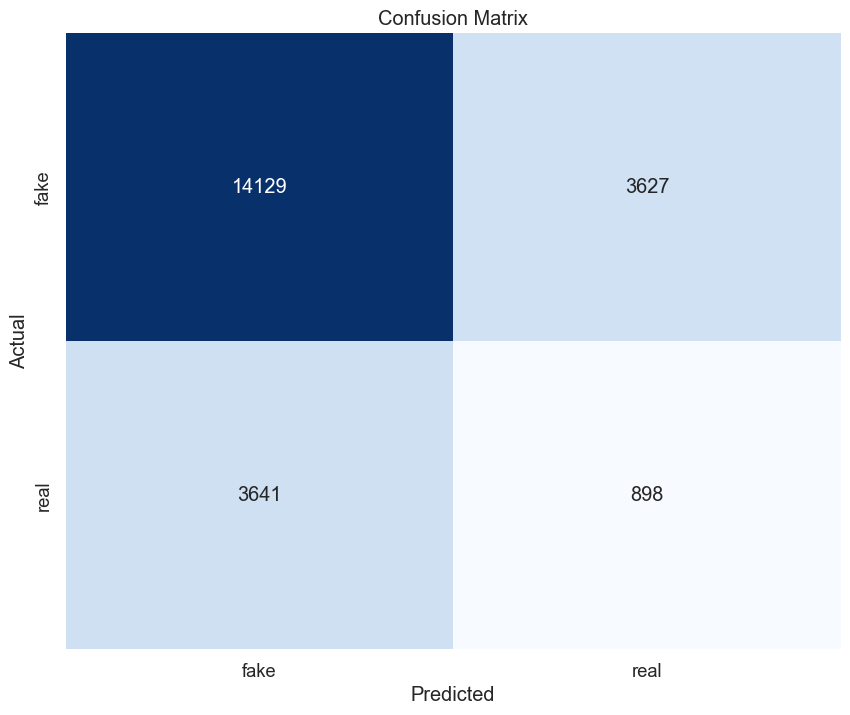

In [52]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [53]:
a1 = history.history['accuracy'][-1]
f1 = history.history['f1_score'][-1]
p1 = history.history['precision_m'][-1]
r1 = history.history['recall_m'][-1]
mae1 = history.history['mae'][-1]
mse1 = history.history['mse'][-1]
specificity1 = history.history['specificity_m'][-1]  
sensitivity1 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a1 * 100))
print('Precision = ' + str(p1 * 100))
print('F1 Score = ' + str(f1 * 100))
print('Recall = ' + str(r1 * 100))
print('MAE = ' + str(mae1))
print('MSE = ' + str(mse1))
print('Sensitivity = ' + str(sensitivity1 * 100))  
print('Specificity = ' + str(specificity1 * 100))

Accuracy = 99.32493567466736
Precision = 99.32523369789124
F1 Score = 99.32523369789124
Recall = 99.32523369789124
MAE = 0.010218358598649502
MSE = 0.005169989541172981
Sensitivity = 99.32523369789124
Specificity = 99.32523369789124


# CNN

In [54]:
model = models.Sequential() 


model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[128, 128, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_211 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_212 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               8

In [55]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [56]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 117s 83ms/step - loss: 0.2601 - accuracy: 0.8906 - f1_score: 0.8906 - recall_m: 0.8906 - precision_m: 0.8906 - specificity_m: 0.8906 - sensitivity_m: 0.8906 - mae: 0.1640 - mse: 0.0806 - val_loss: 0.1085 - val_accuracy: 0.9582 - val_f1_score: 0.9581 - val_recall_m: 0.9581 - val_precision_m: 0.9581 - val_specificity_m: 0.9581 - val_sensitivity_m: 0.9581 - val_mae: 0.0692 - val_mse: 0.0316
Epoch 2/50
1394/1394 [==============================] - 114s 82ms/step - loss: 0.1006 - accuracy: 0.9602 - f1_score: 0.9602 - recall_m: 0.9602 - precision_m: 0.9602 - specificity_m: 0.9602 - sensitivity_m: 0.9602 - mae: 0.0595 - mse: 0.0294 - val_loss: 0.0821 - val_accuracy: 0.9696 - val_f1_score: 0.9696 - val_recall_m: 0.9696 - val_precision_m: 0.9696 - val_specificity_m: 0.9696 - val_sensitivity_m: 0.9696 - val_mae: 0.0442 - val_mse: 0.0230
Epoch 3/50
1394/1394 [==============================] - 114s 81ms/step - loss: 0.0686 - accuracy: 0.9735 -

In [57]:
model.save('models/cnn.h5')

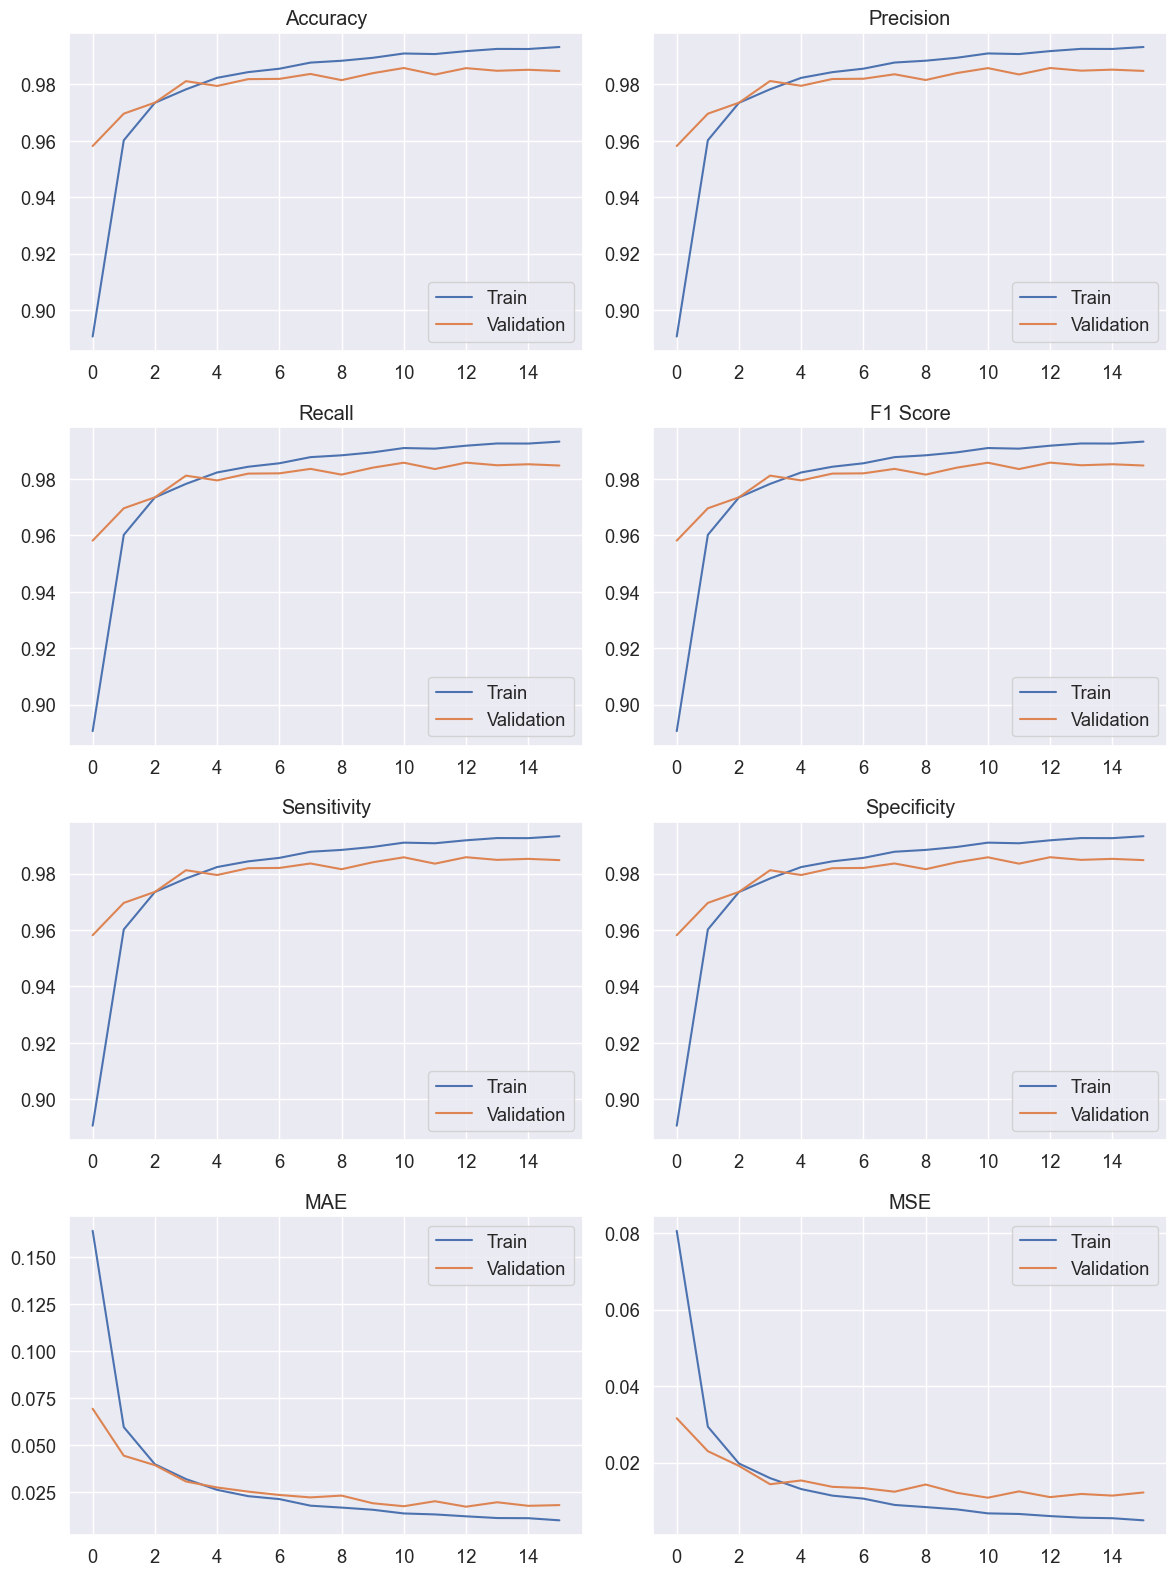

In [58]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 22s 64ms/step


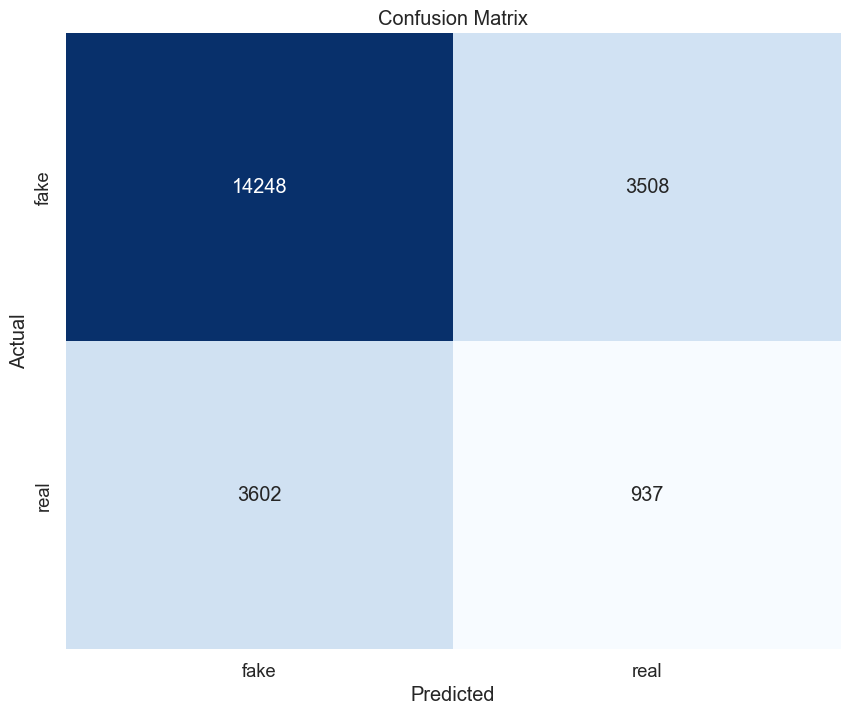

In [59]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [60]:
a2 = history.history['accuracy'][-1]
f2 = history.history['f1_score'][-1]
p2 = history.history['precision_m'][-1]
r2 = history.history['recall_m'][-1]
mae2 = history.history['mae'][-1]
mse2 = history.history['mse'][-1]
specificity2 = history.history['specificity_m'][-1]  
sensitivity2 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a2 * 100))
print('Precision = ' + str(p2 * 100))
print('F1 Score = ' + str(f2 * 100))
print('Recall = ' + str(r2 * 100))
print('MAE = ' + str(mae2))
print('MSE = ' + str(mse2))
print('Sensitivity = ' + str(sensitivity2 * 100))  
print('Specificity = ' + str(specificity2 * 100))

Accuracy = 99.32718276977539
Precision = 99.3257224559784
F1 Score = 99.3257224559784
Recall = 99.3257224559784
MAE = 0.009794571436941624
MSE = 0.004929688759148121
Sensitivity = 99.3257224559784
Specificity = 99.3257224559784


# Xception

In [61]:
inc = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_6[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 16, 16, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_215 (Conv2D)            (None, 8, 8, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 8, 8, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 8, 8, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 8, 8, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 8, 8, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 8, 8, 728)   536536      ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 8, 8, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 8, 8, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 8, 8, 728)   0           ['add_10[0][0]']                 
 on)      

In [62]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [63]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 120s 83ms/step - loss: 0.1235 - accuracy: 0.9521 - f1_score: 0.9521 - recall_m: 0.9521 - precision_m: 0.9521 - specificity_m: 0.9521 - sensitivity_m: 0.9521 - mae: 0.0766 - mse: 0.0362 - val_loss: 0.0381 - val_accuracy: 0.9866 - val_f1_score: 0.9866 - val_recall_m: 0.9866 - val_precision_m: 0.9866 - val_specificity_m: 0.9866 - val_sensitivity_m: 0.9866 - val_mae: 0.0234 - val_mse: 0.0102
Epoch 2/50
1394/1394 [==============================] - 117s 84ms/step - loss: 0.0259 - accuracy: 0.9903 - f1_score: 0.9903 - recall_m: 0.9903 - precision_m: 0.9903 - specificity_m: 0.9903 - sensitivity_m: 0.9903 - mae: 0.0164 - mse: 0.0072 - val_loss: 0.0270 - val_accuracy: 0.9910 - val_f1_score: 0.9910 - val_recall_m: 0.9910 - val_precision_m: 0.9910 - val_specificity_m: 0.9910 - val_sensitivity_m: 0.9910 - val_mae: 0.0142 - val_mse: 0.0071
Epoch 3/50
1394/1394 [==============================] - 117s 84ms/step - loss: 0.0123 - accuracy: 0.9957 -

In [64]:
model.save('models/Xception.h5')

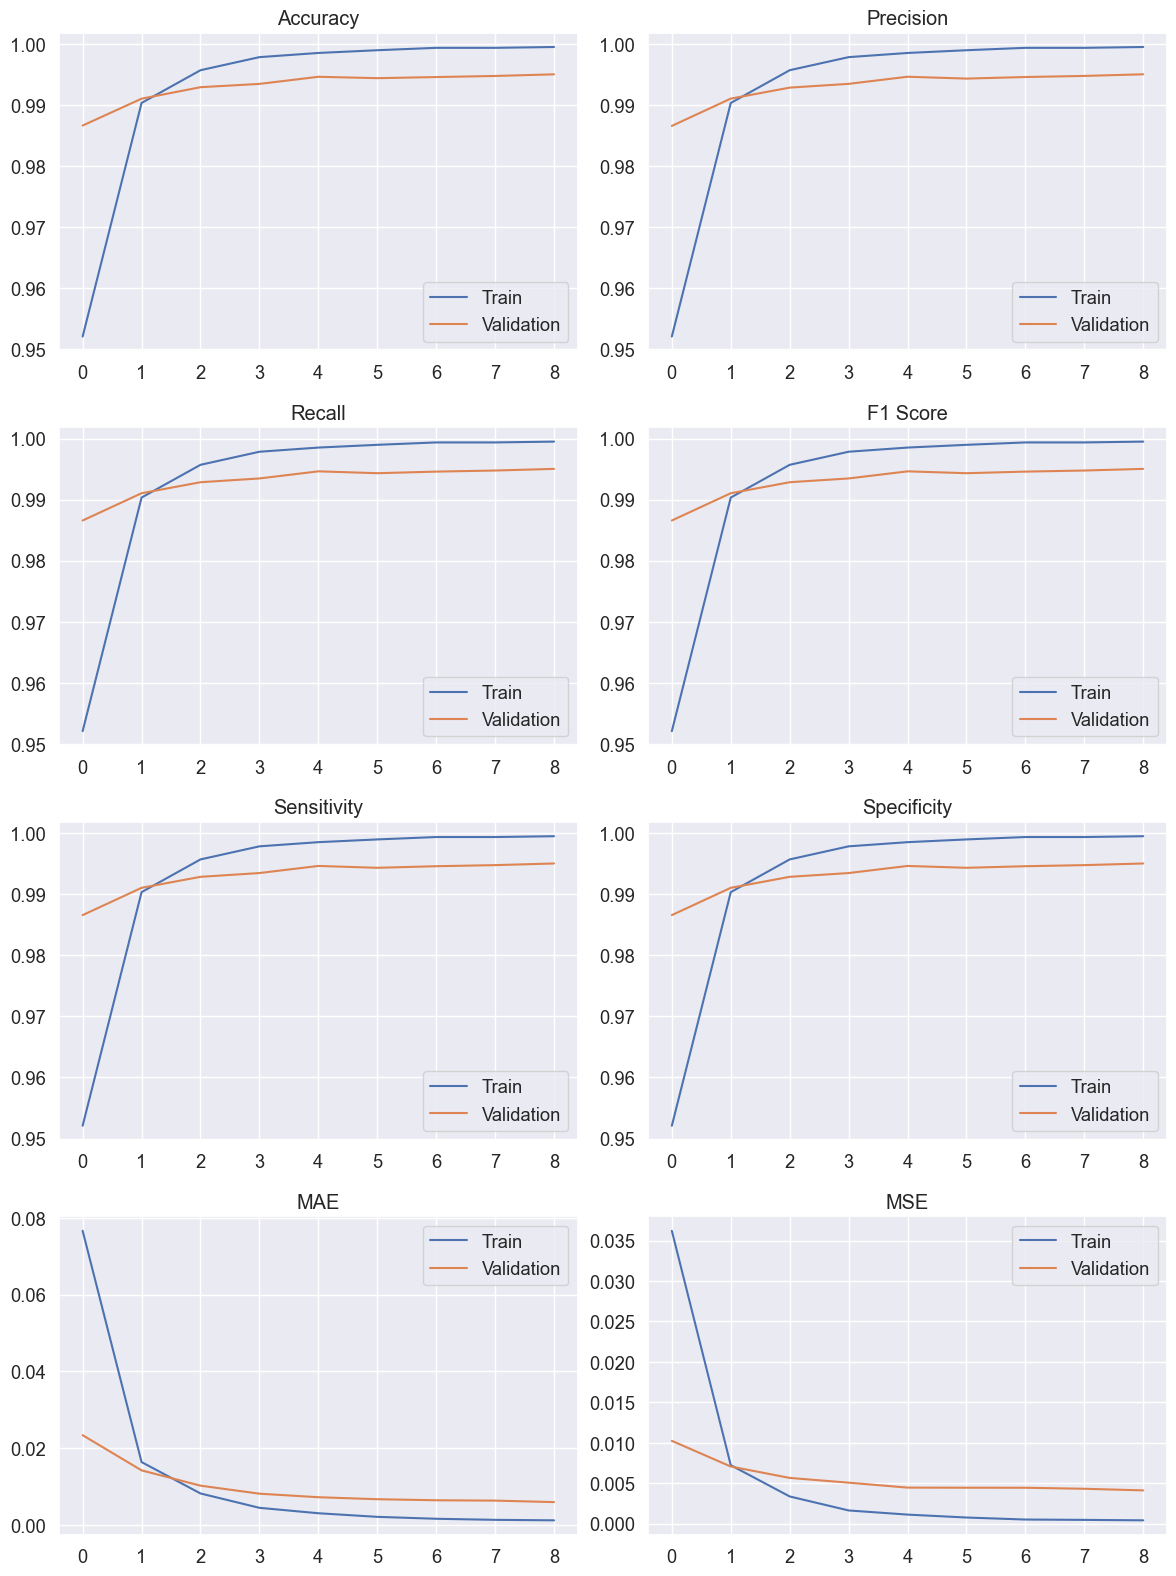

In [65]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 23s 64ms/step


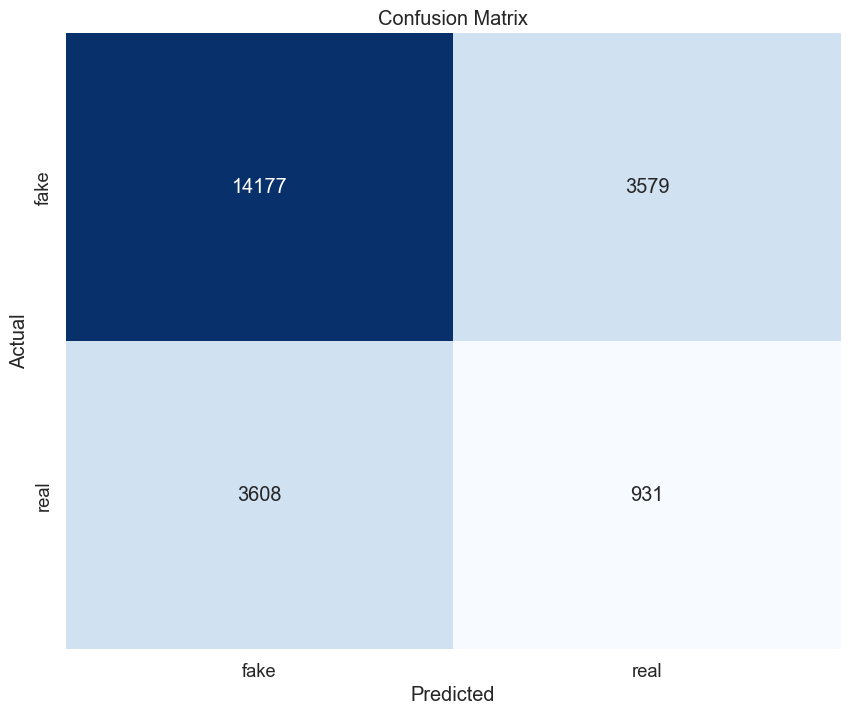

In [66]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [67]:
a3 = history.history['accuracy'][-1]
f3 = history.history['f1_score'][-1]
p3 = history.history['precision_m'][-1]
r3 = history.history['recall_m'][-1]
mae3 = history.history['mae'][-1]
mse3 = history.history['mse'][-1]
specificity3 = history.history['specificity_m'][-1]  
sensitivity3 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a3 * 100))
print('Precision = ' + str(p3 * 100))
print('F1 Score = ' + str(f3 * 100))
print('Recall = ' + str(r3 * 100))
print('MAE = ' + str(mae3))
print('MSE = ' + str(mse3))
print('Sensitivity = ' + str(sensitivity3 * 100))  
print('Specificity = ' + str(specificity3 * 100))

Accuracy = 99.94953870773315
Precision = 99.94956254959106
F1 Score = 99.94956254959106
Recall = 99.94956254959106
MAE = 0.001195399323478341
MSE = 0.00041073589818552136
Sensitivity = 99.94956254959106
Specificity = 99.94956254959106


# NASNetMobile

In [68]:
inc = tf.keras.applications.NASNetMobile(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 63, 63, 32)   864         ['input_7[0][0]']                
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 63, 63, 32)   128         ['stem_conv1[0][0]']             
                                                                                                  
 activation_203 (Activation)    (None, 63, 63, 32)   0           ['stem_bn1[0][0]']         

 right2_stem_1 (BatchNormalizat                                  t2_stem_1[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 32, 32, 11)  1152        ['separable_conv_1_pad_reduction_
 ht3_stem_1 (SeparableConv2D)                                    right3_stem_1[0][0]']            
                                                                                                  
 separable_conv_1_reduction_lef  (None, 32, 32, 11)  220         ['activation_212[0][0]']         
 t4_stem_1 (SeparableConv2D)                                                                      
                                                                                                  
 activation_209 (Activation)    (None, 32, 32, 11)   0           ['separable_conv_1_bn_reduction_r
          

                                                                                                  
 reduction_concat_stem_1 (Conca  (None, 32, 32, 44)  0           ['reduction_add_2_stem_1[0][0]', 
 tenate)                                                          'reduction_add3_stem_1[0][0]',  
                                                                  'add_12[0][0]',                 
                                                                  'reduction_add4_stem_1[0][0]']  
                                                                                                  
 adjust_avg_pool_1_stem_2 (Aver  (None, 32, 32, 32)  0           ['adjust_relu_1_stem_2[0][0]']   
 agePooling2D)                                                                                    
                                                                                                  
 adjust_avg_pool_2_stem_2 (Aver  (None, 32, 32, 32)  0           ['cropping2d[0][0]']             
 agePoolin

 reduction_add_1_stem_2 (Add)   (None, 16, 16, 22)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft1_stem_2[0][0]',              
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight1_stem_2[0][0]']             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 16, 16, 22)  1562        ['separable_conv_1_pad_reduction_
 ht2_stem_2 (SeparableConv2D)                                    right2_stem_2[0][0]']            
                                                                                                  
 separable_conv_1_pad_reduction  (None, 35, 35, 22)  0           ['activation_221[0][0]']         
 _right3_stem_2 (ZeroPadding2D)                                                                   
          

 D)                                                                                               
                                                                                                  
 reduction_add3_stem_2 (Add)    (None, 16, 16, 22)   0           ['reduction_left3_stem_2[0][0]', 
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight3_stem_2[0][0]']             
                                                                                                  
 add_13 (Add)                   (None, 16, 16, 22)   0           ['reduction_add_2_stem_2[0][0]', 
                                                                  'reduction_left4_stem_2[0][0]'] 
                                                                                                  
 reduction_add4_stem_2 (Add)    (None, 16, 16, 22)   0           ['separable_conv_2_bn_reduction_l
          

 activation_227 (Activation)    (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_0[0][0]']                      
                                                                                                  
 activation_229 (Activation)    (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_0[0][0]']                     
                                                                                                  
 activation_231 (Activation)    (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 2_0[0][0]']                      
                                                                                                  
 activation_233 (Activation)    (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
          

 activation_237 (Activation)    (None, 16, 16, 264)  0           ['normal_concat_0[0][0]']        
                                                                                                  
 adjust_conv_projection_1 (Conv  (None, 16, 16, 44)  3872        ['activation_236[0][0]']         
 2D)                                                                                              
                                                                                                  
 normal_conv_1_1 (Conv2D)       (None, 16, 16, 44)   11616       ['activation_237[0][0]']         
                                                                                                  
 adjust_bn_1 (BatchNormalizatio  (None, 16, 16, 44)  176         ['adjust_conv_projection_1[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn

 separable_conv_2_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_2_normal_left1_1
 t1_1 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 44)  176         ['separable_conv_2_normal_right1_
 ht1_1 (BatchNormalization)                                      1[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_2_normal_left2_1
 t2_1 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 16, 16, 44)  176         ['separable_conv_2_normal_right2_
 ht2_1 (Ba

 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_normal_right2  (None, 16, 16, 44)  2332        ['activation_256[0][0]']         
 _2 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left5_  (None, 16, 16, 44)  2332        ['activation_258[0][0]']         
 2 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 16, 16, 44)  176         ['separable_conv_1_normal_left1_2
 t1_2 (BatchNormalization)                                       [0][0]']                         
          

                                                                 2_2[0][0]',                      
                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_2[0][0]']                     
                                                                                                  
 normal_add_3_2 (Add)           (None, 16, 16, 44)   0           ['normal_left3_2[0][0]',         
                                                                  'adjust_bn_2[0][0]']            
                                                                                                  
 normal_add_4_2 (Add)           (None, 16, 16, 44)   0           ['normal_left4_2[0][0]',         
                                                                  'normal_right4_2[0][0]']        
                                                                                                  
 normal_ad

                                                                 2_3[0][0]']                      
                                                                                                  
 activation_269 (Activation)    (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_3[0][0]']                     
                                                                                                  
 activation_271 (Activation)    (None, 16, 16, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 5_3[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 16, 16, 44)  3036        ['activation_263[0][0]']         
 3 (SeparableConv2D)                                                                              
          

                                                                                                  
 reduction_bn_1_reduce_4 (Batch  (None, 16, 16, 88)  352         ['reduction_conv_1_reduce_4[0][0]
 Normalization)                                                  ']                               
                                                                                                  
 adjust_bn_reduce_4 (BatchNorma  (None, 16, 16, 88)  352         ['adjust_conv_projection_reduce_4
 lization)                                                       [0][0]']                         
                                                                                                  
 activation_274 (Activation)    (None, 16, 16, 88)   0           ['reduction_bn_1_reduce_4[0][0]']
                                                                                                  
 activation_276 (Activation)    (None, 16, 16, 88)   0           ['adjust_bn_reduce_4[0][0]']     
          

 separable_conv_1_reduction_lef  (None, 8, 8, 88)    8536        ['activation_282[0][0]']         
 t4_reduce_4 (SeparableConv2D)                                                                    
                                                                                                  
 activation_279 (Activation)    (None, 8, 8, 88)     0           ['separable_conv_1_bn_reduction_r
                                                                 ight2_reduce_4[0][0]']           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 8, 8, 88)    352         ['separable_conv_1_reduction_righ
 right3_reduce_4 (BatchNormaliz                                  t3_reduce_4[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable

                                                                  'reduction_add4_reduce_4[0][0]']
                                                                                                  
 adjust_avg_pool_1_5 (AveragePo  (None, 8, 8, 264)   0           ['adjust_relu_1_5[0][0]']        
 oling2D)                                                                                         
                                                                                                  
 adjust_avg_pool_2_5 (AveragePo  (None, 8, 8, 264)   0           ['cropping2d_2[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 adjust_conv_1_5 (Conv2D)       (None, 8, 8, 44)     11616       ['adjust_avg_pool_1_5[0][0]']    
                                                                                                  
 adjust_co

                                                                                                  
 separable_conv_2_normal_right1  (None, 8, 8, 88)    8536        ['activation_288[0][0]']         
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 8, 8, 88)    9944        ['activation_290[0][0]']         
 5 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 8, 8, 88)    8536        ['activation_292[0][0]']         
 _5 (SeparableConv2D)                                                                             
                                                                                                  
 separable

                                                                                                  
 activation_301 (Activation)    (None, 8, 8, 88)     0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activation_303 (Activation)    (None, 8, 8, 88)     0           ['adjust_bn_6[0][0]']            
                                                                                                  
 activation_305 (Activation)    (None, 8, 8, 88)     0           ['normal_bn_1_6[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 8, 8, 88)    9944        ['activation_297[0][0]']         
 6 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 2D)                                                                                              
                                                                                                  
 normal_right4_6 (AveragePoolin  (None, 8, 8, 88)    0           ['adjust_bn_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_2_normal_left5_6
 t5_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_6 (Add)           (None, 8, 8, 88)     0           ['separable_conv_2_bn_normal_left
                                                                 1_6[0][0]',                      
          

                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 8, 8, 88)    352         ['separable_conv_1_normal_right2_
 ht2_7 (BatchNormalization)                                      7[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_1_normal_left5_7
 t5_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_310 (Activation)    (None, 8, 8, 88)     0           ['separable_conv_1_bn_normal_left
                                                                 1_7[0][0]']                      
                                                                                                  
 activatio

                                                                  'normal_add_2_7[0][0]',         
                                                                  'normal_add_3_7[0][0]',         
                                                                  'normal_add_4_7[0][0]',         
                                                                  'normal_add_5_7[0][0]']         
                                                                                                  
 activation_319 (Activation)    (None, 8, 8, 528)    0           ['normal_concat_6[0][0]']        
                                                                                                  
 activation_320 (Activation)    (None, 8, 8, 528)    0           ['normal_concat_7[0][0]']        
                                                                                                  
 adjust_conv_projection_8 (Conv  (None, 8, 8, 88)    46464       ['activation_319[0][0]']         
 2D)      

                                                                                                  
 separable_conv_2_normal_right2  (None, 8, 8, 88)    8536        ['activation_328[0][0]']         
 _8 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 8, 8, 88)    8536        ['activation_330[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 8, 8, 88)    352         ['separable_conv_2_normal_left1_8
 t1_8 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

 _right1_reduce_8 (ZeroPadding2                                                                   
 D)                                                                                               
                                                                                                  
 separable_conv_1_reduction_lef  (None, 4, 4, 176)   35376       ['separable_conv_1_pad_reduction_
 t1_reduce_8 (SeparableConv2D)                                   left1_reduce_8[0][0]']           
                                                                                                  
 separable_conv_1_reduction_rig  (None, 4, 4, 176)   39600       ['separable_conv_1_pad_reduction_
 ht1_reduce_8 (SeparableConv2D)                                  right1_reduce_8[0][0]']          
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 4, 4, 176)   704         ['separable_conv_1_reduction_left
 left1_red

                                                                                                  
 separable_conv_2_reduction_rig  (None, 4, 4, 176)   39600       ['activation_338[0][0]']         
 ht2_reduce_8 (SeparableConv2D)                                                                   
                                                                                                  
 activation_340 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_reduction_r
                                                                 ight3_reduce_8[0][0]']           
                                                                                                  
 activation_342 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_reduction_l
                                                                 eft4_reduce_8[0][0]']            
                                                                                                  
 reduction

                                                                  'adjust_conv_2_9[0][0]']        
                                                                                                  
 normal_conv_1_9 (Conv2D)       (None, 4, 4, 176)    123904      ['activation_343[0][0]']         
                                                                                                  
 adjust_bn_9 (BatchNormalizatio  (None, 4, 4, 176)   704         ['concatenate_3[0][0]']          
 n)                                                                                               
                                                                                                  
 normal_bn_1_9 (BatchNormalizat  (None, 4, 4, 176)   704         ['normal_conv_1_9[0][0]']        
 ion)                                                                                             
                                                                                                  
 activatio

 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right1_
 ht1_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 4, 4, 176)   704         ['separable_conv_2_normal_left2_9
 t2_9 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right2_
 ht2_9 (BatchNormalization)                                      9[0][0]']                        
                                                                                                  
 normal_left3_9 (AveragePooling  (None, 4, 4, 176)   0           ['normal_bn_1_9[0][0]']          
 2D)      

 separable_conv_1_normal_right2  (None, 4, 4, 176)   32560       ['activation_362[0][0]']         
 _10 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_1_normal_left5_  (None, 4, 4, 176)   32560       ['activation_364[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 4, 4, 176)   704         ['separable_conv_1_normal_left1_1
 t1_10 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_1_normal_right1_
 ht1_10 (B

                                                                 t2_10[0][0]']                    
                                                                                                  
 normal_add_3_10 (Add)          (None, 4, 4, 176)    0           ['normal_left3_10[0][0]',        
                                                                  'adjust_bn_10[0][0]']           
                                                                                                  
 normal_add_4_10 (Add)          (None, 4, 4, 176)    0           ['normal_left4_10[0][0]',        
                                                                  'normal_right4_10[0][0]']       
                                                                                                  
 normal_add_5_10 (Add)          (None, 4, 4, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 5_10[0][0]',                     
          

 activation_375 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_normal_righ
                                                                 t2_11[0][0]']                    
                                                                                                  
 activation_377 (Activation)    (None, 4, 4, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 5_11[0][0]']                     
                                                                                                  
 separable_conv_2_normal_left1_  (None, 4, 4, 176)   35376       ['activation_369[0][0]']         
 11 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_right1  (None, 4, 4, 176)   32560       ['activation_371[0][0]']         
 _11 (Sepa

                                                                                                  
 normal_bn_1_12 (BatchNormaliza  (None, 4, 4, 176)   704         ['normal_conv_1_12[0][0]']       
 tion)                                                                                            
                                                                                                  
 activation_380 (Activation)    (None, 4, 4, 176)    0           ['normal_bn_1_12[0][0]']         
                                                                                                  
 activation_382 (Activation)    (None, 4, 4, 176)    0           ['adjust_bn_12[0][0]']           
                                                                                                  
 activation_384 (Activation)    (None, 4, 4, 176)    0           ['adjust_bn_12[0][0]']           
                                                                                                  
 activatio

 separable_conv_2_bn_normal_rig  (None, 4, 4, 176)   704         ['separable_conv_2_normal_right2_
 ht2_12 (BatchNormalization)                                     12[0][0]']                       
                                                                                                  
 normal_left3_12 (AveragePoolin  (None, 4, 4, 176)   0           ['normal_bn_1_12[0][0]']         
 g2D)                                                                                             
                                                                                                  
 normal_left4_12 (AveragePoolin  (None, 4, 4, 176)   0           ['adjust_bn_12[0][0]']           
 g2D)                                                                                             
                                                                                                  
 normal_right4_12 (AveragePooli  (None, 4, 4, 176)   0           ['adjust_bn_12[0][0]']           
 ng2D)    

In [69]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [70]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 183s 119ms/step - loss: 0.1417 - accuracy: 0.9470 - f1_score: 0.9470 - recall_m: 0.9470 - precision_m: 0.9470 - specificity_m: 0.9470 - sensitivity_m: 0.9470 - mae: 0.0783 - mse: 0.0399 - val_loss: 0.6573 - val_accuracy: 0.7308 - val_f1_score: 0.7305 - val_recall_m: 0.7305 - val_precision_m: 0.7305 - val_specificity_m: 0.7305 - val_sensitivity_m: 0.7305 - val_mae: 0.2836 - val_mse: 0.1987
Epoch 2/50
1394/1394 [==============================] - 164s 118ms/step - loss: 0.0364 - accuracy: 0.9867 - f1_score: 0.9868 - recall_m: 0.9868 - precision_m: 0.9868 - specificity_m: 0.9868 - sensitivity_m: 0.9868 - mae: 0.0216 - mse: 0.0102 - val_loss: 0.5137 - val_accuracy: 0.8381 - val_f1_score: 0.8380 - val_recall_m: 0.8380 - val_precision_m: 0.8380 - val_specificity_m: 0.8380 - val_sensitivity_m: 0.8380 - val_mae: 0.1690 - val_mse: 0.1275
Epoch 3/50
1394/1394 [==============================] - 162s 116ms/step - loss: 0.0195 - accuracy: 0.992

In [71]:
model.save('models/Nasnet.h5')

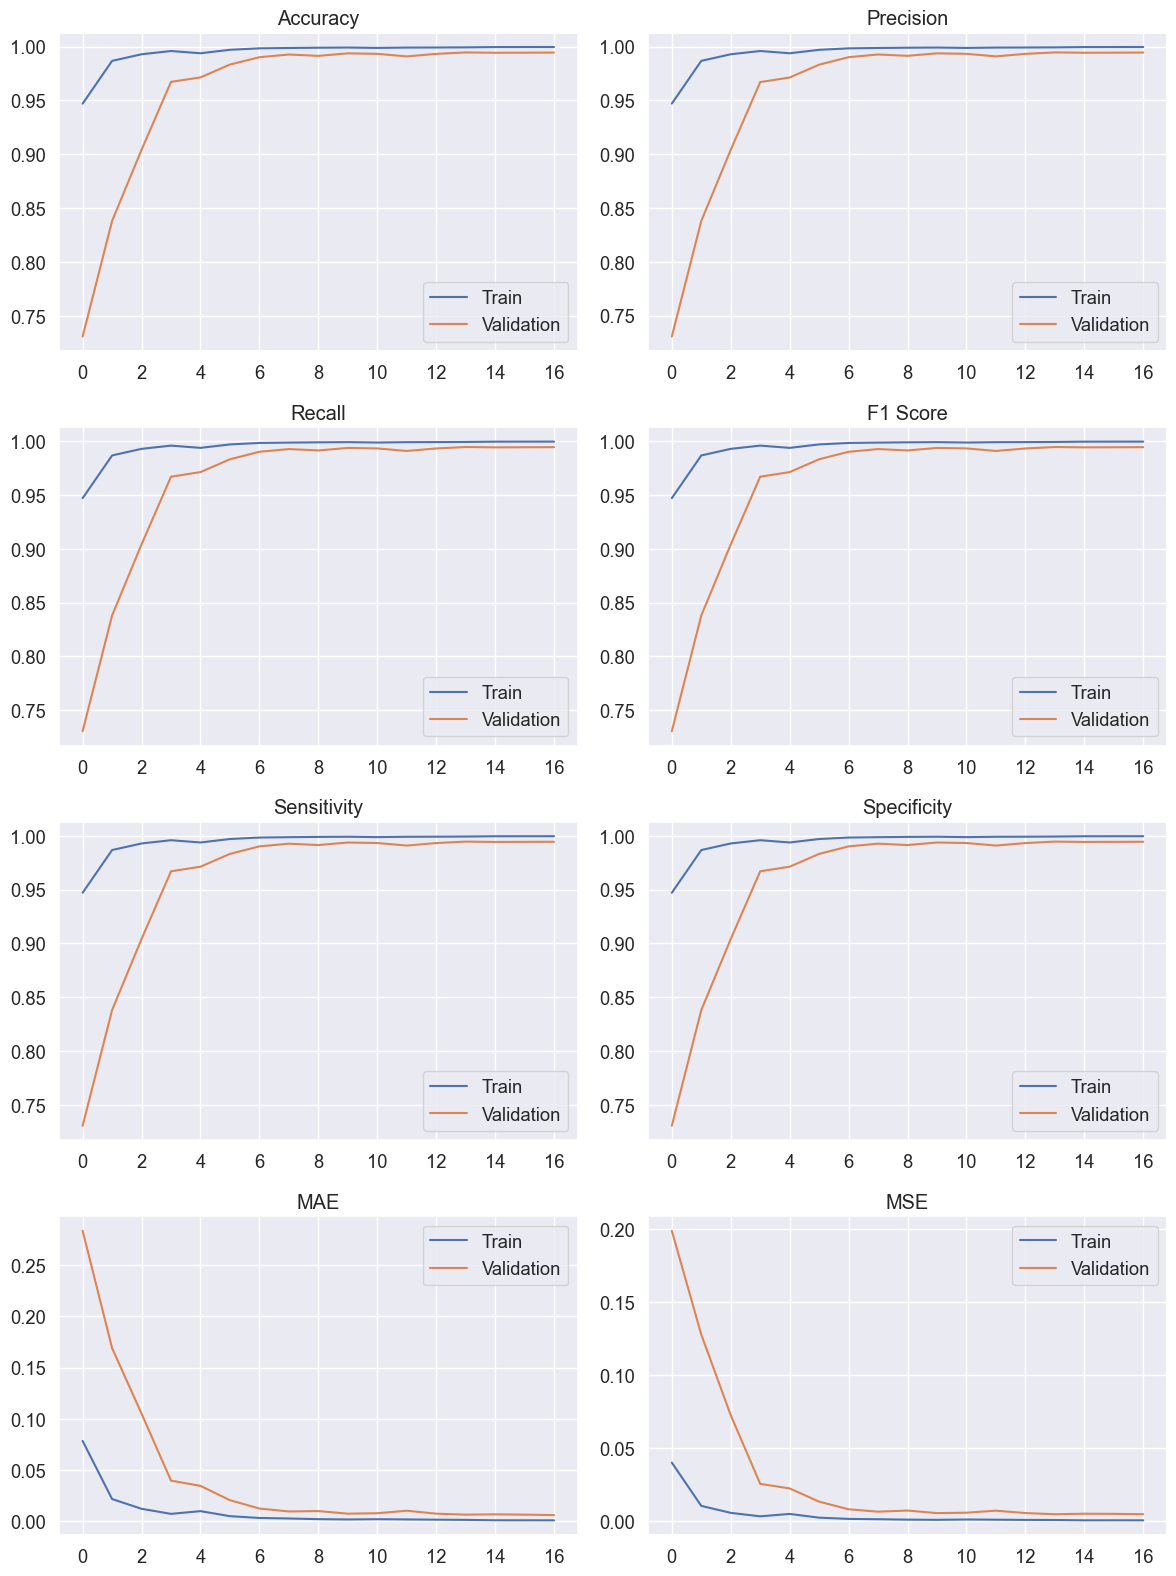

In [72]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 28s 71ms/step


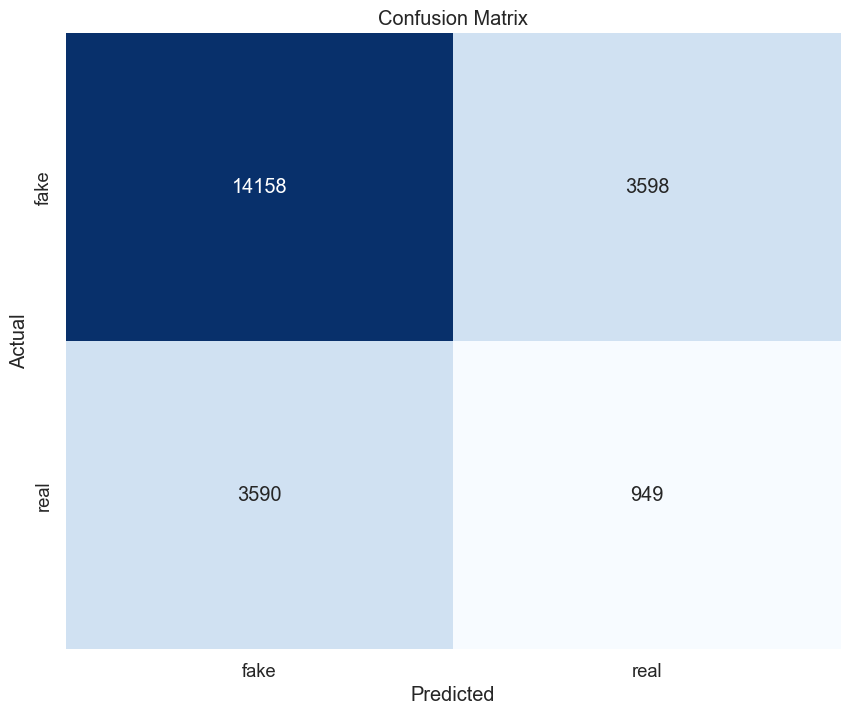

In [73]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [74]:
a4 = history.history['accuracy'][-1]
f4 = history.history['f1_score'][-1]
p4 = history.history['precision_m'][-1]
r4 = history.history['recall_m'][-1]
mae4 = history.history['mae'][-1]
mse4 = history.history['mse'][-1]
specificity4 = history.history['specificity_m'][-1]  
sensitivity4 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a4 * 100))
print('Precision = ' + str(p4 * 100))
print('F1 Score = ' + str(f4 * 100))
print('Recall = ' + str(r4 * 100))
print('MAE = ' + str(mae4))
print('MSE = ' + str(mse4))
print('Sensitivity = ' + str(sensitivity4 * 100))  
print('Specificity = ' + str(specificity4 * 100))

Accuracy = 99.9607503414154
Precision = 99.96076822280884
F1 Score = 99.96076822280884
Recall = 99.96076822280884
MAE = 0.0008420143858529627
MSE = 0.00033198745222762227
Sensitivity = 99.96076822280884
Specificity = 99.96076822280884


# Ensemble

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
import efficientnet.keras

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [8]:
def ensemble():

    model_1 = load_model('models/Xception.h5', compile=False)
    model_1 = Model(inputs = model_1.inputs, outputs = model_1.outputs, name = 'Xception')

    model_2 = load_model('models/Nasnet.h5', compile=False)
    model_2 = Model(inputs = model_2.inputs, outputs = model_2.outputs, name = 'NASNetMobile')
    
    models = [model_1, model_2]


    models_input = Input(shape =(128,128,3))
    models_output = [model(models_input) for model in models]
    
    ensemble_output = Average()(models_output)

    simple_average = Model(inputs = models_input, outputs = ensemble_output, name = 'Extension')

    return simple_average

In [16]:
ext = ensemble()
ext.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
ext.summary()

Model: "Extension"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Xception (Functional)          (None, 2)            20865578    ['input_2[0][0]']                
                                                                                                  
 NASNetMobile (Functional)      (None, 2)            4271830     ['input_2[0][0]']                
                                                                                                  
 average_1 (Average)            (None, 2)            0           ['Xception[0][0]',       

In [79]:
history = ext.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 225s 146ms/step - loss: 6.3259e-04 - accuracy: 0.9999 - f1_score: 0.9999 - recall_m: 0.9999 - precision_m: 0.9999 - specificity_m: 0.9999 - sensitivity_m: 0.9999 - mae: 5.6992e-04 - mse: 9.2973e-05 - val_loss: 0.0141 - val_accuracy: 0.9959 - val_f1_score: 0.9959 - val_recall_m: 0.9959 - val_precision_m: 0.9959 - val_specificity_m: 0.9959 - val_sensitivity_m: 0.9959 - val_mae: 0.0058 - val_mse: 0.0033
Epoch 2/50
1394/1394 [==============================] - 200s 144ms/step - loss: 5.8925e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 5.4285e-04 - mse: 8.7250e-05 - val_loss: 0.0144 - val_accuracy: 0.9960 - val_f1_score: 0.9960 - val_recall_m: 0.9960 - val_precision_m: 0.9960 - val_specificity_m: 0.9960 - val_sensitivity_m: 0.9960 - val_mae: 0.0059 - val_mse: 0.0034
Epoch 3/50
1394/1394 [==============================] - 200s 144ms/step - loss: 

In [18]:
ext.save('models/ensemble.h5')

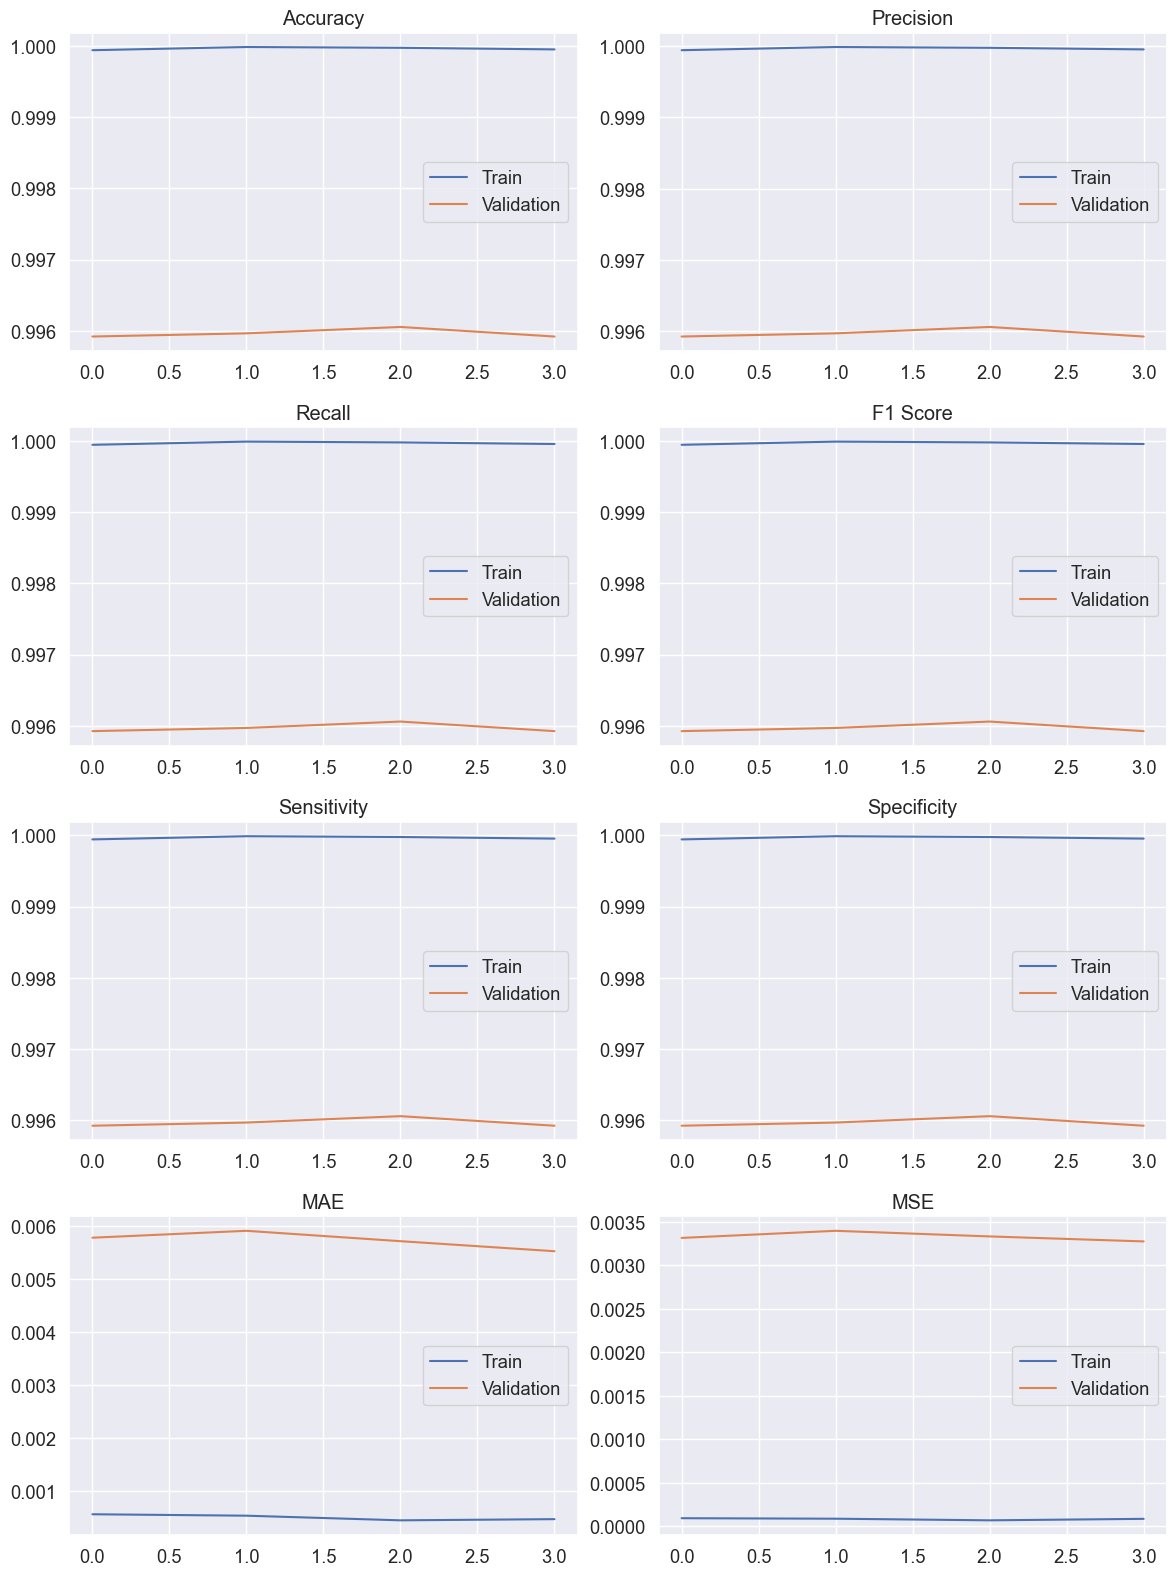

In [81]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 30s 74ms/step


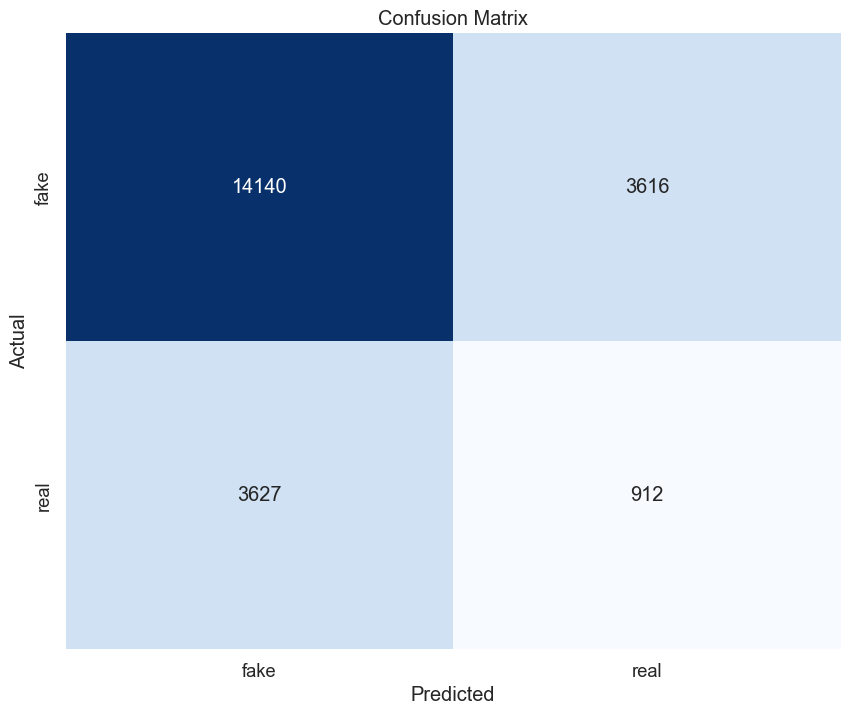

In [82]:
# Evaluate the ext on the validation data
val_evaluation = ext.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = ext.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [83]:
a5 = history.history['accuracy'][-1]
f5 = history.history['f1_score'][-1]
p5 = history.history['precision_m'][-1]
r5 = history.history['recall_m'][-1]
mae5 = history.history['mae'][-1]
mse5 = history.history['mse'][-1]
specificity5 = history.history['specificity_m'][-1]  
sensitivity5 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a5 * 100))
print('Precision = ' + str(p5 * 100))
print('F1 Score = ' + str(f5 * 100))
print('Recall = ' + str(r5 * 100))
print('MAE = ' + str(mae5))
print('MSE = ' + str(mse5))
print('Sensitivity = ' + str(sensitivity5 * 100))  
print('Specificity = ' + str(specificity5 * 100))

Accuracy = 99.99551177024841
Precision = 99.99551773071289
F1 Score = 99.99551773071289
Recall = 99.99551773071289
MAE = 0.0004777177528012544
MSE = 8.563762094127014e-05
Sensitivity = 99.99551773071289
Specificity = 99.99551773071289


# Comparison

In [101]:
results ={'Accuracy': [a,a1,a2,a3,a4,a5],
 'Recall':[r,r1,r2,r3,r4,r5],
 'Precision': [p,p1,p2,p3,p4,p5],
  'F1 Score' : [f,f1,f2,f3,f4,f5],
    'Sensitivity' : [sensitivity,sensitivity1,sensitivity2,sensitivity3,sensitivity4,sensitivity5],
    'Specificity' : [specificity,specificity1,specificity2,specificity3,specificity4,specificity5],
   'MAE' : [mae,mae1,mae2,mae3,mae4,mae5],
    'MSE' : [mse,mse1,mse2,mse3,mse4,mse5]}
index = ['InceptionResnet V2','VGG19','CNN','Xception','NASNetMobile','Ensemble']

In [102]:
results =pd.DataFrame(results,index=index)

In [103]:
print(results)

                    Accuracy    Recall  Precision  F1 Score  Sensitivity  \
InceptionResnet V2  0.982013  0.981986   0.981986  0.981986     0.981986   
VGG19               0.993249  0.993252   0.993252  0.993252     0.993252   
CNN                 0.993272  0.993257   0.993257  0.993257     0.993257   
Xception            0.999495  0.999496   0.999496  0.999496     0.999496   
NASNetMobile        0.999608  0.999608   0.999608  0.999608     0.999608   
Ensemble            0.999955  0.999955   0.999955  0.999955     0.999955   

                    Specificity                                   MAE  \
InceptionResnet V2     0.981986  <function mae at 0x0000011650342680>   
VGG19                  0.993252                              0.010218   
CNN                    0.993257                              0.009795   
Xception               0.999496                              0.001195   
NASNetMobile           0.999608                              0.000842   
Ensemble               0.9999

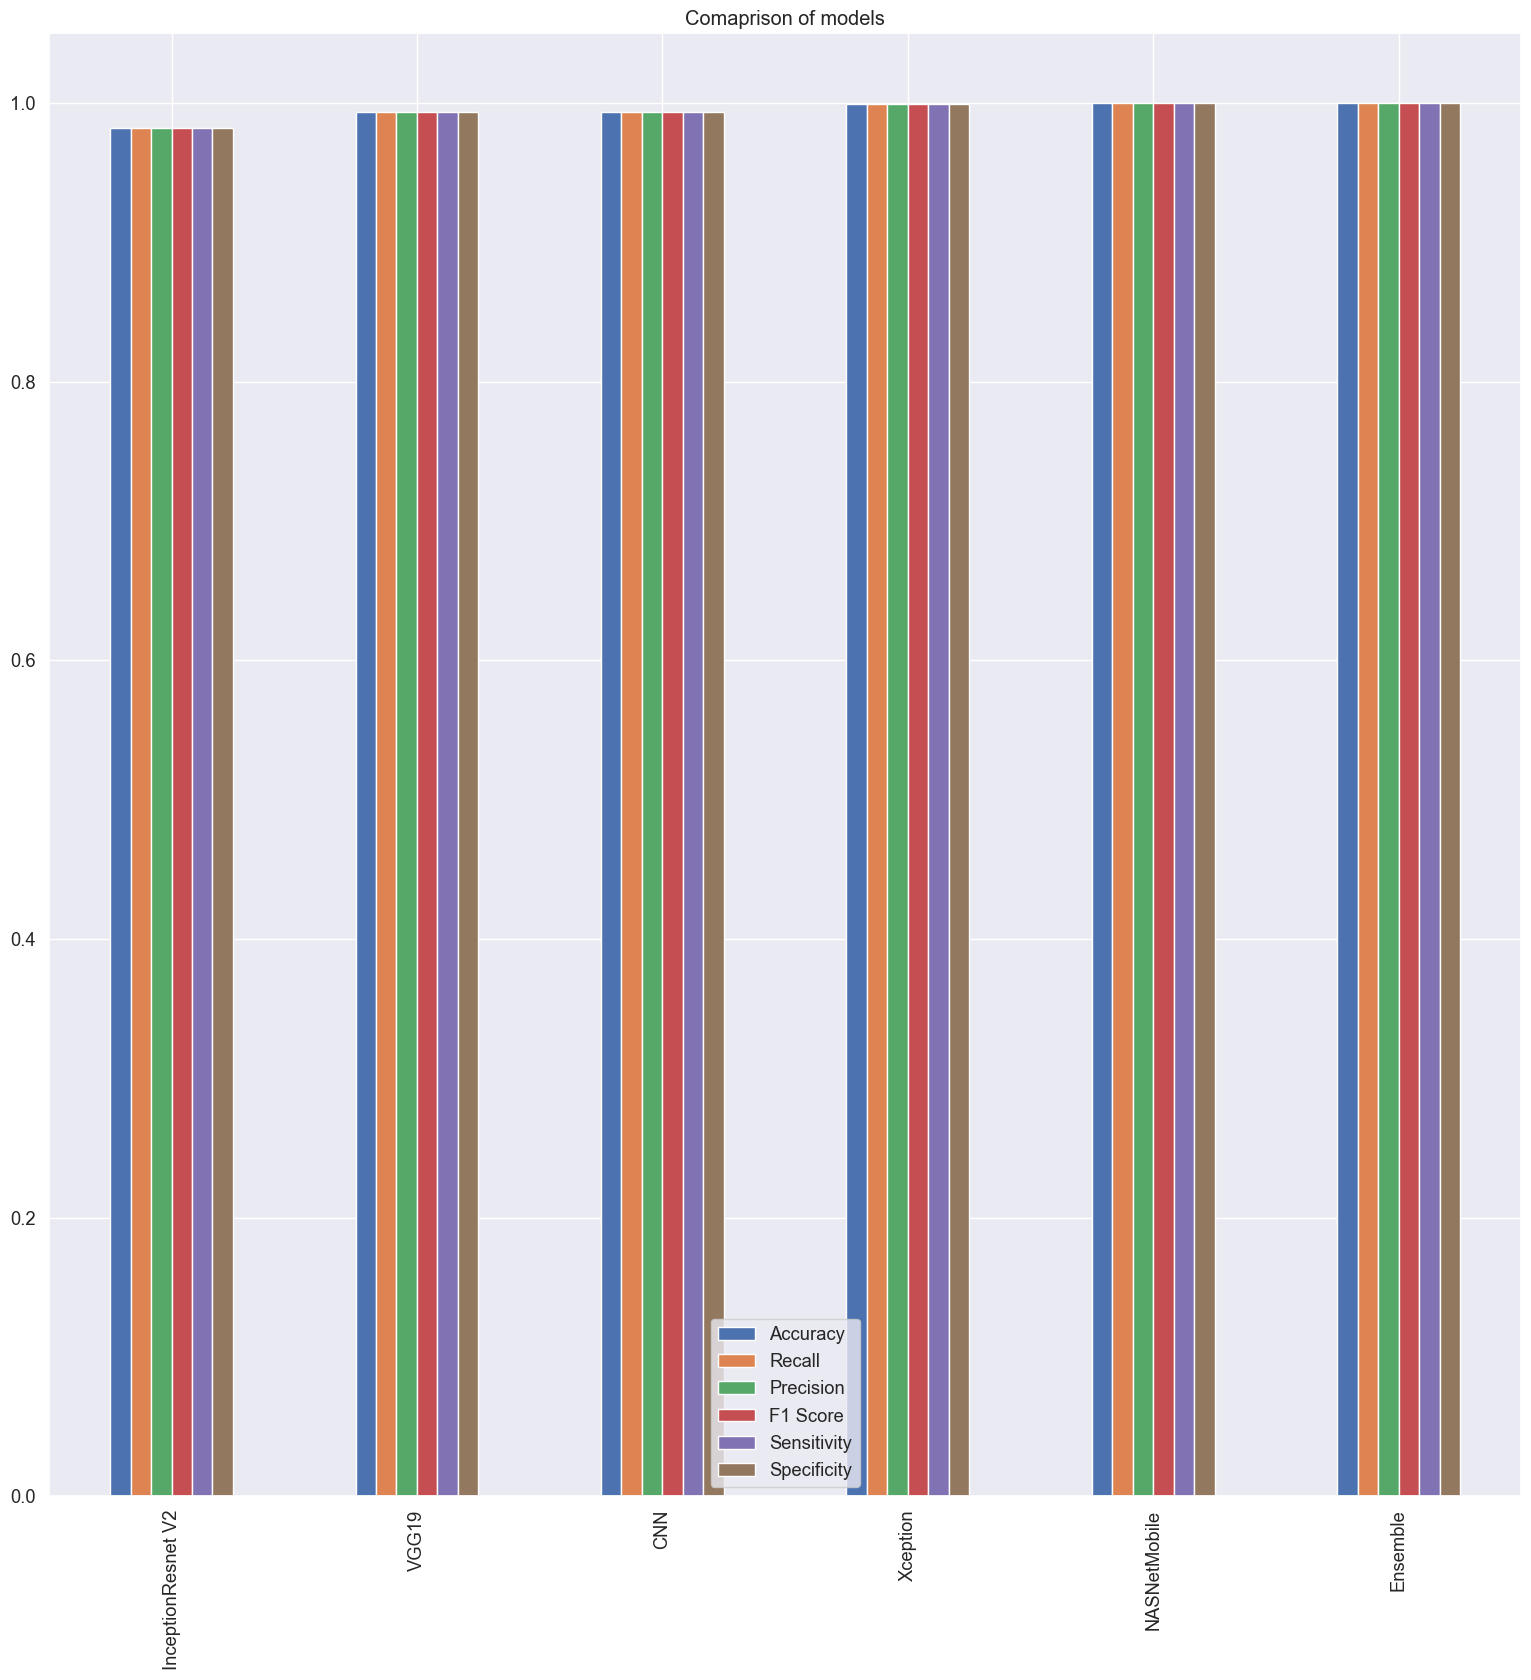

In [104]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

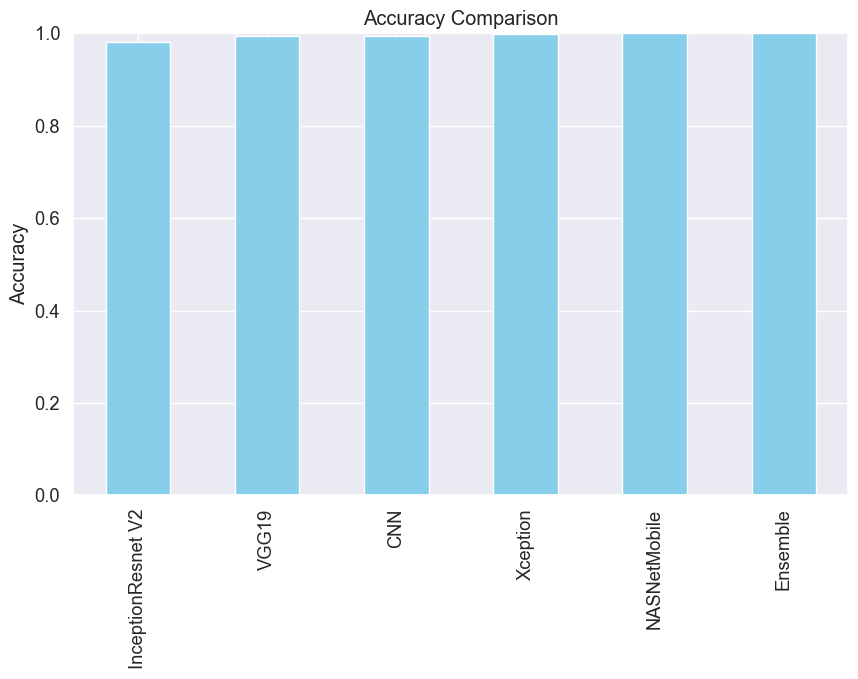

In [111]:
results_df = pd.DataFrame(results, index=['InceptionResnet V2', 'VGG19', 'CNN', 'Xception','NASNetMobile','Ensemble'])

# Plotting Accuracy
plt.figure(figsize=(10, 6))
results_df['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

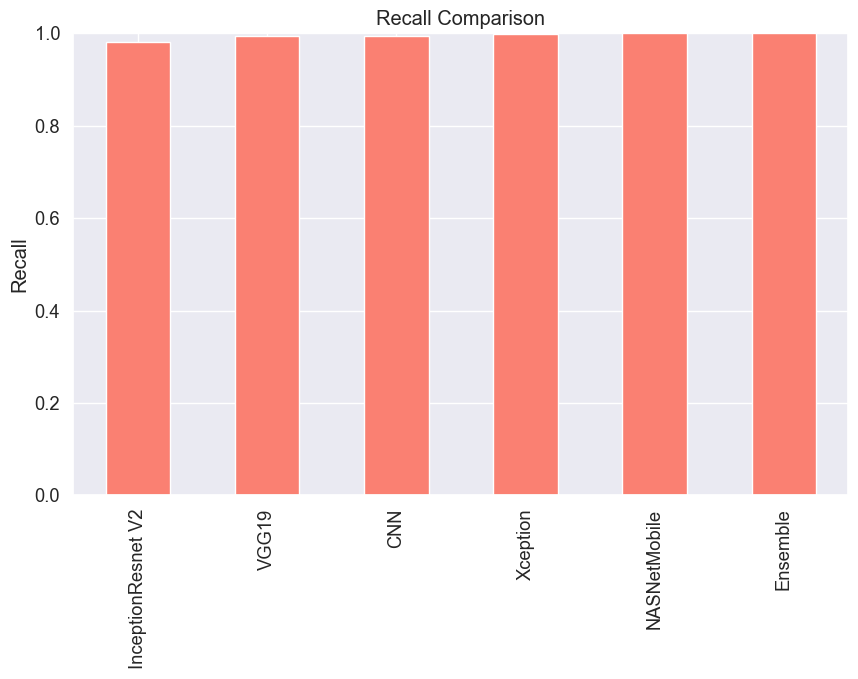

In [112]:
plt.figure(figsize=(10, 6))
results_df['Recall'].plot(kind='bar', color='salmon')
plt.title('Recall Comparison')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.show()

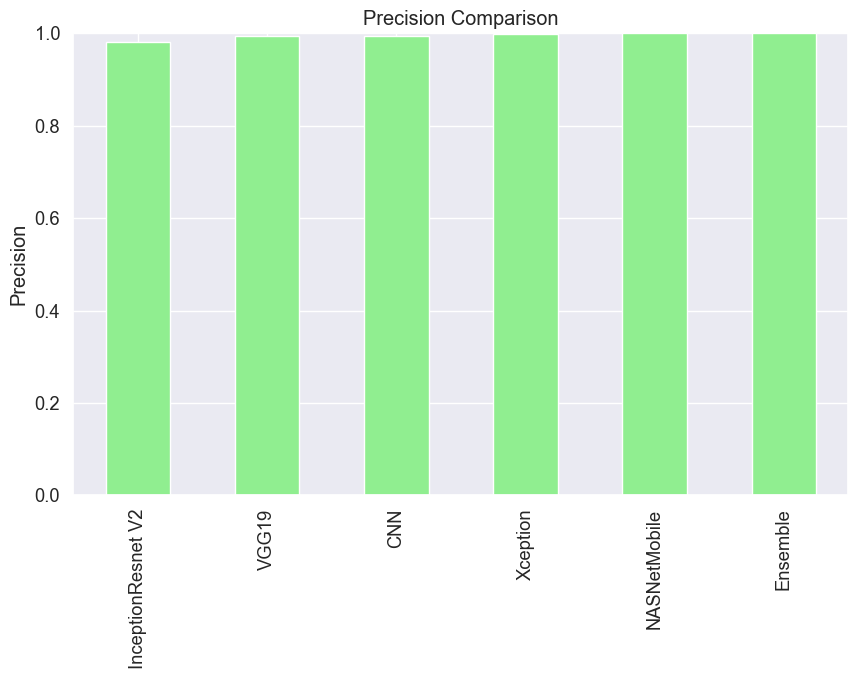

In [113]:
plt.figure(figsize=(10, 6))
results_df['Precision'].plot(kind='bar', color='lightgreen')
plt.title('Precision Comparison')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.show()

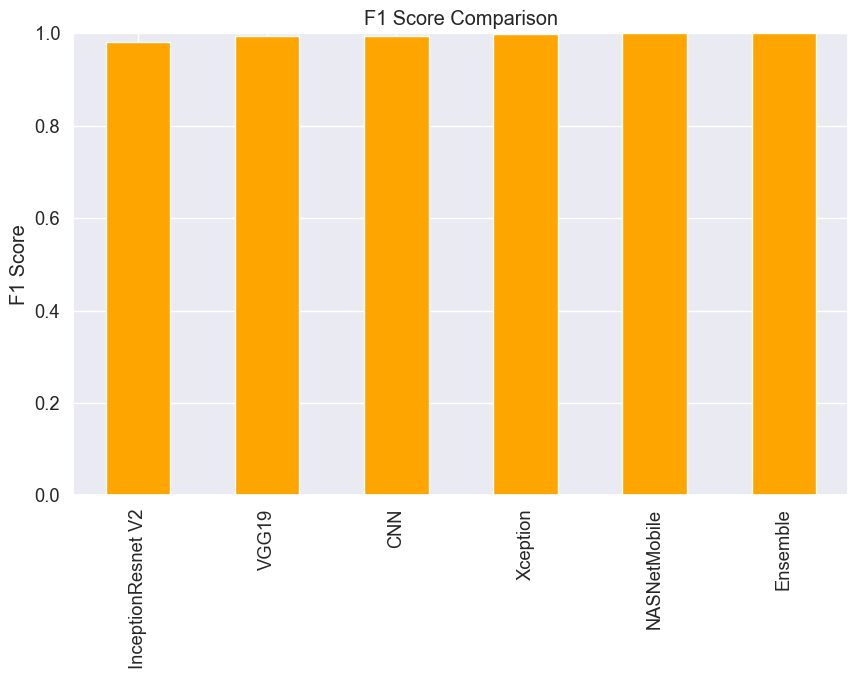

In [114]:
plt.figure(figsize=(10, 6))
results_df['F1 Score'].plot(kind='bar', color='orange')
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

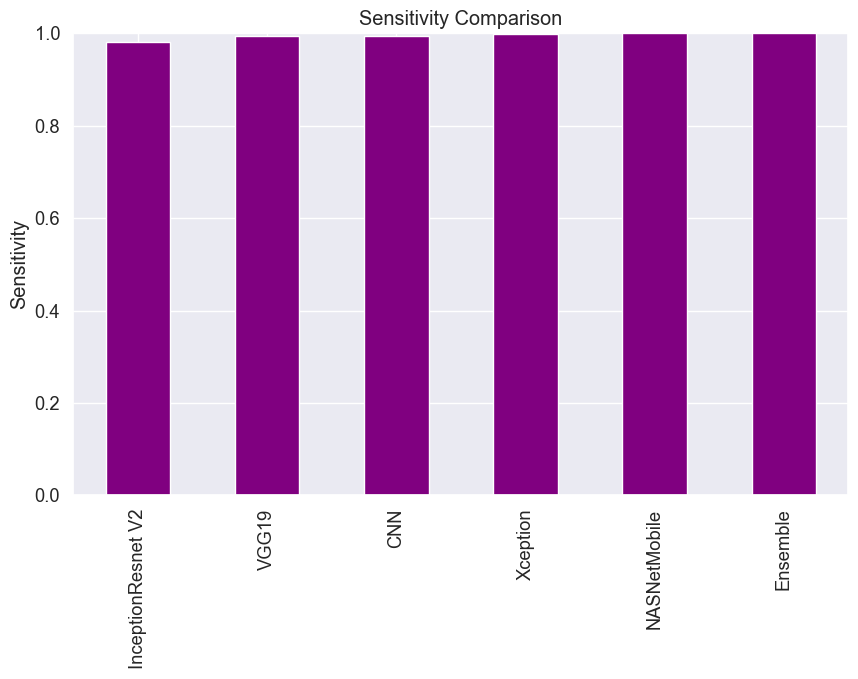

In [115]:
plt.figure(figsize=(10, 6))
results_df['Sensitivity'].plot(kind='bar', color='purple')
plt.title('Sensitivity Comparison')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)
plt.show()

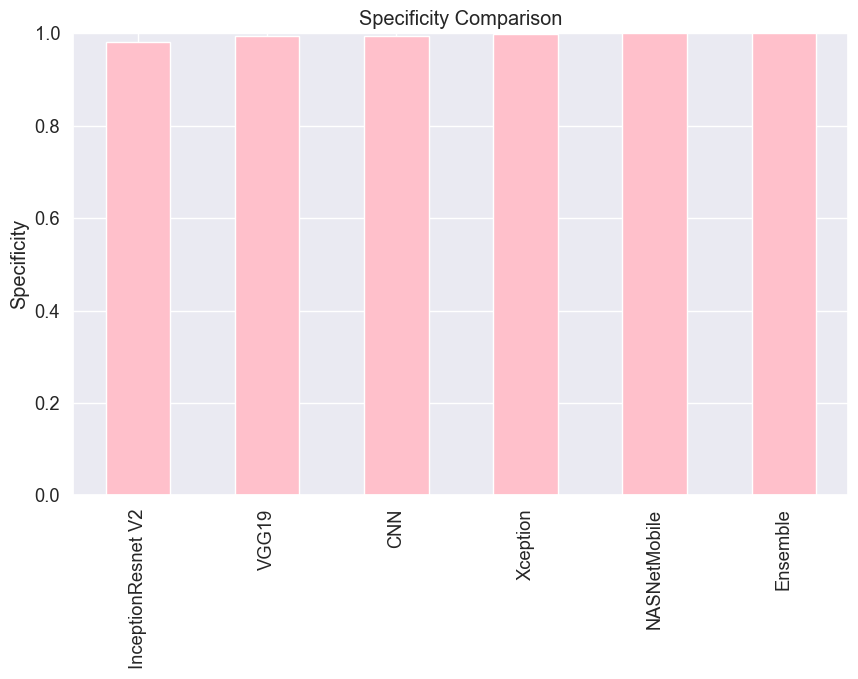

In [116]:
plt.figure(figsize=(10, 6))
results_df['Specificity'].plot(kind='bar', color='pink')
plt.title('Specificity Comparison')
plt.ylabel('Specificity')
plt.ylim(0, 1)
plt.show()